#UAS Bengkel Koding - DS 04
Muhammad Za'im Muzakki

A11.2022.14023

Prediksi Churn Pelanggan Telekomunikasi

UPDATE: Dengan Penanganan Imbalance Data menggunakan class_weight='balanced'

===========================
PENJELASAN PENAMBAHAN CLASS_WEIGHT

===========================

 MENGAPA MENGGUNAKAN CLASS_WEIGHT?

1. EFISIENSI KOMPUTASI
   - Tidak menambah/mengurangi jumlah data
   - Tidak perlu proses resampling (SMOTE, undersampling)
   - Training lebih cepat
   - Memory efficient

2. PRESERVASI DATA ORIGINAL
   - Semua data tetap digunakan (tidak ada yang hilang)
   - Tidak ada risiko overfitting ke data sintetis (seperti SMOTE)
   - Distribusi data original tetap terjaga

3. BUILT-IN SKLEARN
   - Sudah terintegrasi dengan model sklearn
   - Otomatis menghitung bobot optimal dengan 'balanced'
   - Tidak perlu library tambahan (imblearn)

4. COCOK UNTUK CHURN PREDICTION
   - Dataset churn pasti imbalanced (lebih banyak No Churn)
   - Fokus: deteksi kelas minoritas (Churn) lebih penting
   - Cost of missing Churn > Cost of false alarm
   - Meningkatkan Recall untuk kelas Churn

5. INTERPRETASI MUDAH
   - Formula: weight = n_samples / (n_classes * n_samples_per_class)
   - Jika rasio No:Yes = 3:1, maka weight Yes = 3x weight No
   - Model lebih "peduli" saat salah prediksi kelas minoritas

 DIMANA CLASS_WEIGHT DITAMBAHKAN?
   1. Import: compute_class_weight (untuk analisis)
   2. Setelah EDA: Analisis imbalance data (cell baru)
   3. Modeling Direct: Tambah class_weight='balanced' di semua model
   4. Modeling Preprocessing: Tambah class_weight='balanced' di semua model
   5. Hyperparameter Tuning: Tambah 'class_weight': ['balanced'] di param_grids
   6. Save Model: Simpan info class_weight

In [39]:
# ============================================================================
# IMPORT LIBRARY
# ============================================================================

# Library dasar
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight  # ← BARU: untuk analisis imbalance

# Library modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Library evaluasi
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

# Library hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Library untuk menyimpan model
import joblib
import pickle

print("✅ Semua library berhasil diimport!")

✅ Semua library berhasil diimport!


In [40]:
# ============================================================================
# LOAD DATASET
# ============================================================================

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Baca dataset dari Google Drive
path = '/content/drive/MyDrive/Bengkel Koding/UAS/Dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Load dataset
df = pd.read_csv(path)

# Informasi dataset
print("\nDataset berhasil dimuat dari Google Drive!")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Dataset berhasil dimuat dari Google Drive!
Jumlah baris: 7043
Jumlah kolom: 21


#1. EDA - Exploratory Data Analysis

In [41]:
# ============================================================================
# 1.1. Eksplorasi Awal
# ============================================================================

print("\n1.1. EKSPLORASI AWAL")
print("-" * 80)

# Tampilkan 5 baris pertama
print("\n5 Baris Pertama Dataset:")
df.head()


1.1. EKSPLORASI AWAL
--------------------------------------------------------------------------------

5 Baris Pertama Dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [42]:
# Ringkasan informasi dataset
print("\nInformasi Dataset:")
df.info()


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

In [43]:
# Statistik deskriptif
print("\nStatistik Deskriptif:")
df.describe()


Statistik Deskriptif:


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [44]:
# Statistik deskriptif untuk kolom kategorikal
print("\nStatistik Deskriptif Kolom Kategorikal:")
df.describe(include='object')


Statistik Deskriptif Kolom Kategorikal:


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [47]:
# ============================================================================
# 1.2. Identifikasi Missing Value
# ============================================================================

print("\n1.2. IDENTIFIKASI MISSING VALUE")
print("-" * 80)

# Hitung jumlah dan persentase missing value
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Buat DataFrame untuk missing value
missing_df = pd.DataFrame({
    'Kolom': missing_values.index,
    'Jumlah Missing': missing_values.values,
    'Persentase Missing': missing_percentage.values
})

# Filter hanya kolom yang memiliki missing value
missing_df = missing_df[missing_df['Jumlah Missing'] > 0].sort_values('Jumlah Missing', ascending=False)

print("\nMissing Value per Kolom:")
print(missing_df)


1.2. IDENTIFIKASI MISSING VALUE
--------------------------------------------------------------------------------

Missing Value per Kolom:
Empty DataFrame
Columns: [Kolom, Jumlah Missing, Persentase Missing]
Index: []


In [48]:
# Visualisasi missing value
if len(missing_df) > 0:
    plt.figure(figsize=(12, 6))
    plt.bar(missing_df['Kolom'], missing_df['Persentase Missing'], color='coral')
    plt.xlabel('Kolom', fontsize=12)
    plt.ylabel('Persentase Missing Value (%)', fontsize=12)
    plt.title('Persentase Missing Value per Kolom', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nTidak ada missing value dalam dataset!")


Tidak ada missing value dalam dataset!


In [49]:
# Cek tipe data TotalCharges (seharusnya numeric tapi tercatat sebagai object)
print(f"\nTipe data TotalCharges: {df['TotalCharges'].dtype}")


Tipe data TotalCharges: object


In [50]:
# Cek apakah ada nilai non-numeric di TotalCharges
if df['TotalCharges'].dtype == 'object':
    print("\nContoh nilai TotalCharges (5 pertama):")
    print(df['TotalCharges'].head(10))

    # Cek nilai unique yang bukan angka
    non_numeric = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()]['TotalCharges'].unique()
    print(f"\nNilai non-numeric dalam TotalCharges: {non_numeric}")
    print(f"Jumlah nilai non-numeric: {len(df[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()])}")


Contoh nilai TotalCharges (5 pertama):
0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
5      820.5
6     1949.4
7      301.9
8    3046.05
9    3487.95
Name: TotalCharges, dtype: object

Nilai non-numeric dalam TotalCharges: [' ']
Jumlah nilai non-numeric: 11



1.3. VISUALISASI DISTRIBUSI TARGET (CHURN)
--------------------------------------------------------------------------------

Distribusi Variabel Target (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Persentase:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


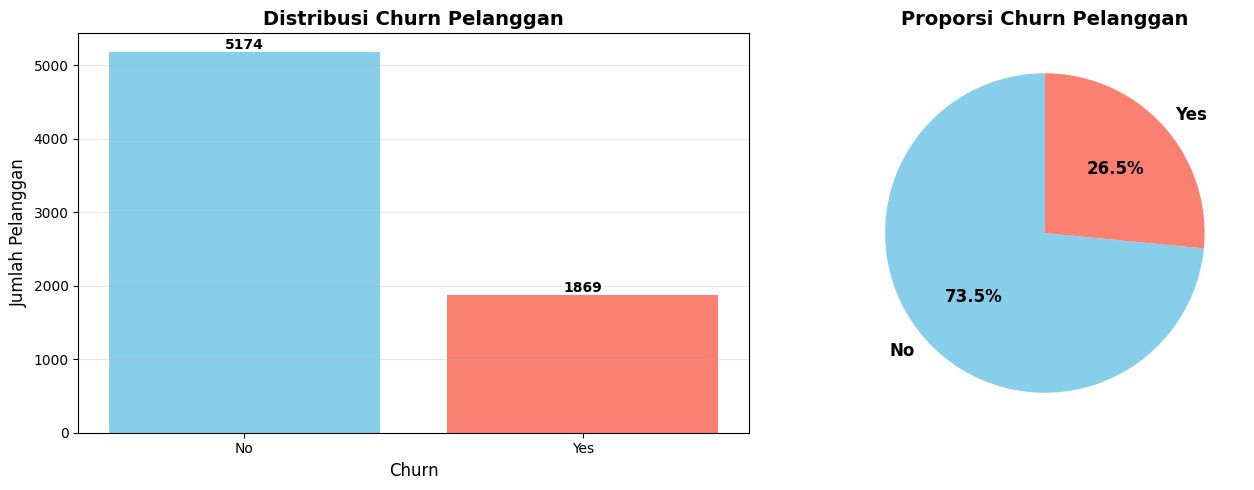

In [51]:
# ============================================================================
# 1.3. Visualisasi Distribusi Target
# ============================================================================

print("\n1.3. VISUALISASI DISTRIBUSI TARGET (CHURN)")
print("-" * 80)

# Hitung distribusi target
churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100

print("\nDistribusi Variabel Target (Churn):")
print(churn_counts)
print("\nPersentase:")
print(churn_percentage)

# Visualisasi distribusi target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(churn_counts.index, churn_counts.values, color=['skyblue', 'salmon'])
axes[0].set_xlabel('Churn', fontsize=12)
axes[0].set_ylabel('Jumlah Pelanggan', fontsize=12)
axes[0].set_title('Distribusi Churn Pelanggan', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Tambahkan label jumlah di atas bar
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['skyblue', 'salmon']
axes[1].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Proporsi Churn Pelanggan', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [52]:
# Interpretasi(Pemberian kesan) keseimbangan kelas
ratio = churn_counts.min() / churn_counts.max()
print(f"\nRasio kelas minoritas terhadap mayoritas: {ratio:.2f}")
if ratio < 0.3:
    print("Dataset SANGAT TIDAK SEIMBANG (Highly Imbalanced)")
elif ratio < 0.5:
    print("Dataset TIDAK SEIMBANG (Imbalanced)")
elif ratio < 0.7:
    print("Dataset CUKUP SEIMBANG (Moderately Balanced)")
else:
    print("Dataset SEIMBANG (Balanced)")


Rasio kelas minoritas terhadap mayoritas: 0.36
Dataset TIDAK SEIMBANG (Imbalanced)


In [53]:
# ============================================================================
# 1.4. Analisis Korelasi
# ============================================================================

print("\n1.4. ANALISIS KORELASI FITUR NUMERIK")
print("-" * 80)

# Identifikasi kolom numerik
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nKolom numerik: {numeric_cols}")

# Buat copy dataframe untuk analisis korelasi
df_corr = df.copy()

# Convert TotalCharges ke numeric jika masih object
if df_corr['TotalCharges'].dtype == 'object':
    df_corr['TotalCharges'] = pd.to_numeric(df_corr['TotalCharges'], errors='coerce')

# Encode variabel target untuk korelasi
df_corr['Churn_Encoded'] = df_corr['Churn'].map({'No': 0, 'Yes': 1})

# Pilih kolom numerik termasuk target yang sudah di-encode
numeric_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Encoded']
df_numeric = df_corr[numeric_features].dropna()

# Hitung matriks korelasi
correlation_matrix = df_numeric.corr()

print("\nMatriks Korelasi:")
print(correlation_matrix)


1.4. ANALISIS KORELASI FITUR NUMERIK
--------------------------------------------------------------------------------

Kolom numerik: ['SeniorCitizen', 'tenure', 'MonthlyCharges']

Matriks Korelasi:
                SeniorCitizen    tenure  MonthlyCharges  TotalCharges  \
SeniorCitizen        1.000000  0.015683        0.219874      0.102411   
tenure               0.015683  1.000000        0.246862      0.825880   
MonthlyCharges       0.219874  0.246862        1.000000      0.651065   
TotalCharges         0.102411  0.825880        0.651065      1.000000   
Churn_Encoded        0.150541 -0.354049        0.192858     -0.199484   

                Churn_Encoded  
SeniorCitizen        0.150541  
tenure              -0.354049  
MonthlyCharges       0.192858  
TotalCharges        -0.199484  
Churn_Encoded        1.000000  


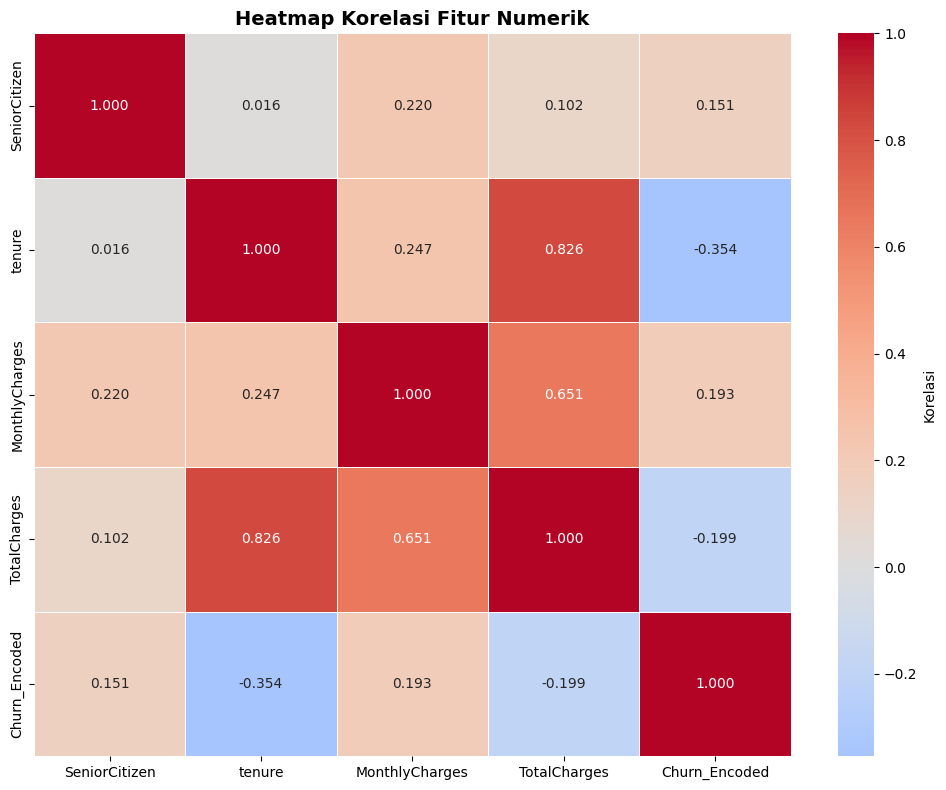

In [54]:
# Visualisasi heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.3f', linewidths=0.5, cbar_kws={'label': 'Korelasi'})
plt.title('Heatmap Korelasi Fitur Numerik', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [55]:
# Analisis korelasi dengan target
print("\nKorelasi Fitur dengan Target (Churn):")
churn_correlation = correlation_matrix['Churn_Encoded'].sort_values(ascending=False)
print(churn_correlation)


Korelasi Fitur dengan Target (Churn):
Churn_Encoded     1.000000
MonthlyCharges    0.192858
SeniorCitizen     0.150541
TotalCharges     -0.199484
tenure           -0.354049
Name: Churn_Encoded, dtype: float64


In [56]:
# Interpretasi
print("\nInterpretasi Korelasi dengan Churn:")
for feature, corr_value in churn_correlation.items():
    if feature != 'Churn_Encoded':
        if abs(corr_value) >= 0.3:
            strength = "KUAT"
        elif abs(corr_value) >= 0.1:
            strength = "SEDANG"
        else:
            strength = "LEMAH"

        direction = "POSITIF" if corr_value > 0 else "NEGATIF"
        print(f"  - {feature}: {corr_value:.3f} ({strength}, {direction})")


Interpretasi Korelasi dengan Churn:
  - MonthlyCharges: 0.193 (SEDANG, POSITIF)
  - SeniorCitizen: 0.151 (SEDANG, POSITIF)
  - TotalCharges: -0.199 (SEDANG, NEGATIF)
  - tenure: -0.354 (KUAT, NEGATIF)



1.5. ANALISIS DISTRIBUSI FITUR PENTING
--------------------------------------------------------------------------------


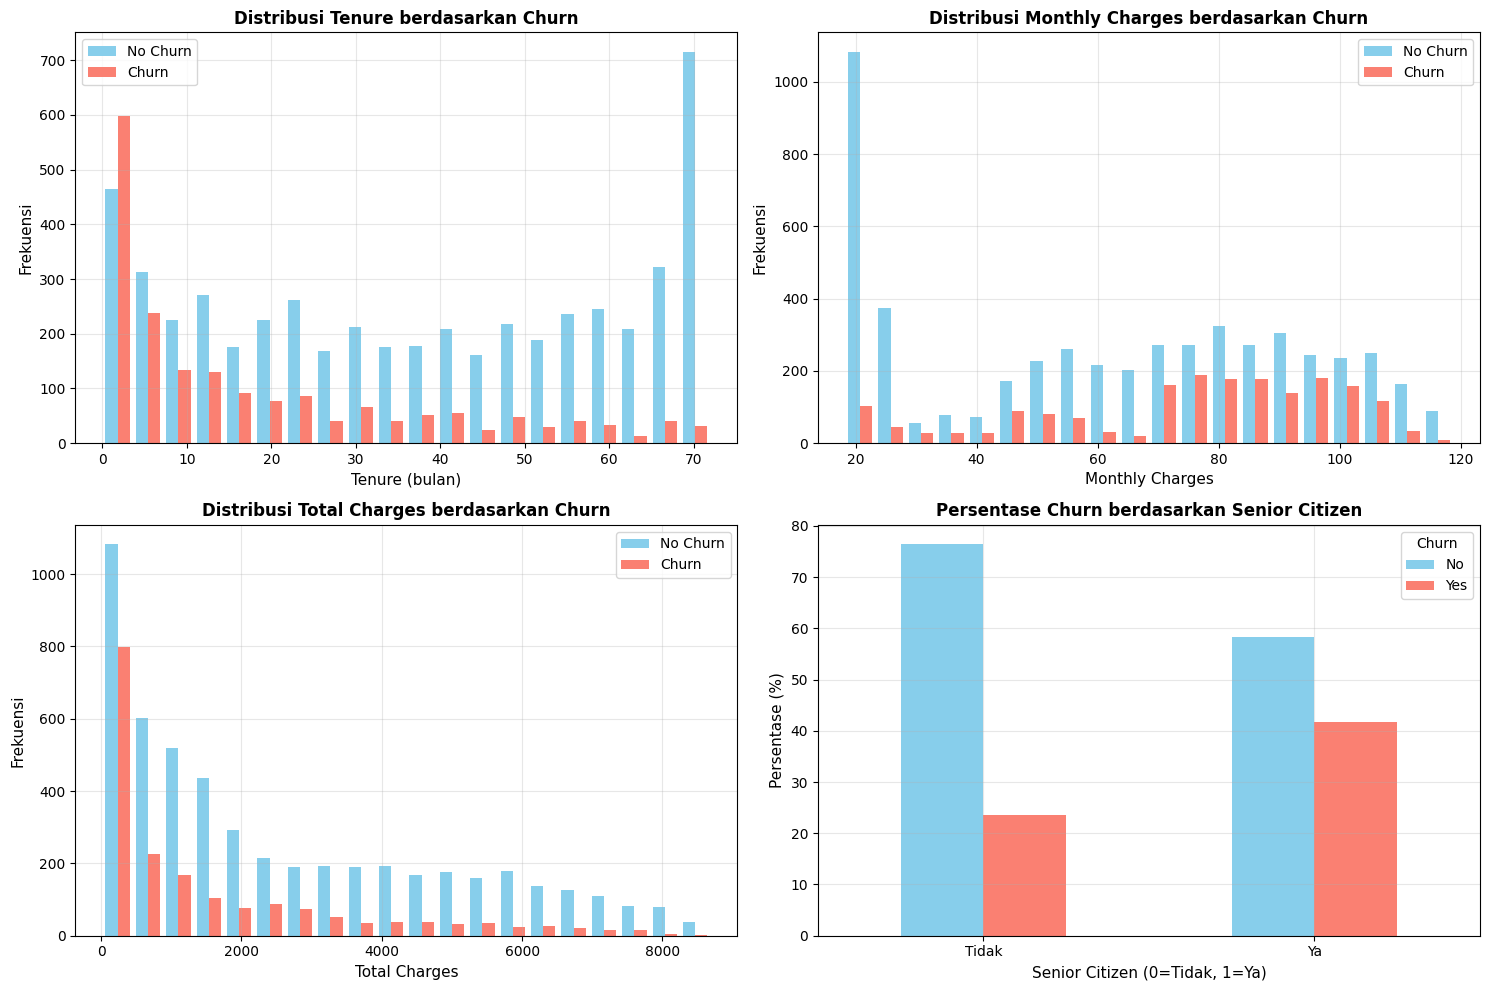


EDA selesai!


In [57]:
# ============================================================================
# ANALISIS TAMBAHAN: DISTRIBUSI FITUR PENTING
# ============================================================================

print("\n1.5. ANALISIS DISTRIBUSI FITUR PENTING")
print("-" * 80)

# Visualisasi distribusi fitur numerik terhadap Churn
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# tenure
axes[0, 0].hist([df[df['Churn']=='No']['tenure'], df[df['Churn']=='Yes']['tenure']],
                bins=20, label=['No Churn', 'Churn'], color=['skyblue', 'salmon'])
axes[0, 0].set_xlabel('Tenure (bulan)', fontsize=11)
axes[0, 0].set_ylabel('Frekuensi', fontsize=11)
axes[0, 0].set_title('Distribusi Tenure berdasarkan Churn', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# MonthlyCharges
axes[0, 1].hist([df[df['Churn']=='No']['MonthlyCharges'], df[df['Churn']=='Yes']['MonthlyCharges']],
                bins=20, label=['No Churn', 'Churn'], color=['skyblue', 'salmon'])
axes[0, 1].set_xlabel('Monthly Charges', fontsize=11)
axes[0, 1].set_ylabel('Frekuensi', fontsize=11)
axes[0, 1].set_title('Distribusi Monthly Charges berdasarkan Churn', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# TotalCharges (convert dulu jika perlu)
df_plot = df.copy()
if df_plot['TotalCharges'].dtype == 'object':
    df_plot['TotalCharges'] = pd.to_numeric(df_plot['TotalCharges'], errors='coerce')

axes[1, 0].hist([df_plot[df_plot['Churn']=='No']['TotalCharges'].dropna(),
                 df_plot[df_plot['Churn']=='Yes']['TotalCharges'].dropna()],
                bins=20, label=['No Churn', 'Churn'], color=['skyblue', 'salmon'])
axes[1, 0].set_xlabel('Total Charges', fontsize=11)
axes[1, 0].set_ylabel('Frekuensi', fontsize=11)
axes[1, 0].set_title('Distribusi Total Charges berdasarkan Churn', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# SeniorCitizen
senior_churn = pd.crosstab(df['SeniorCitizen'], df['Churn'], normalize='index') * 100
senior_churn.plot(kind='bar', ax=axes[1, 1], color=['skyblue', 'salmon'])
axes[1, 1].set_xlabel('Senior Citizen (0=Tidak, 1=Ya)', fontsize=11)
axes[1, 1].set_ylabel('Persentase (%)', fontsize=11)
axes[1, 1].set_title('Persentase Churn berdasarkan Senior Citizen', fontsize=12, fontweight='bold')
axes[1, 1].legend(title='Churn')
axes[1, 1].set_xticklabels(['Tidak', 'Ya'], rotation=0)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEDA selesai!")

#Analisis Imbalance Data


 ANALISIS IMBALANCE DATA

  Dataset churn biasanya imbalanced (lebih banyak yang tidak churn)
    Kita akan menggunakan class_weight='balanced' untuk menangani ini

Distribusi Kelas Target (Churn):
--------------------------------------------------
  No   :  5174 samples (73.46%)
  Yes  :  1869 samples (26.54%)

 Rasio Imbalance: 2.77:1
   Untuk setiap 1 customer 'Yes', ada 3 customer 'No'


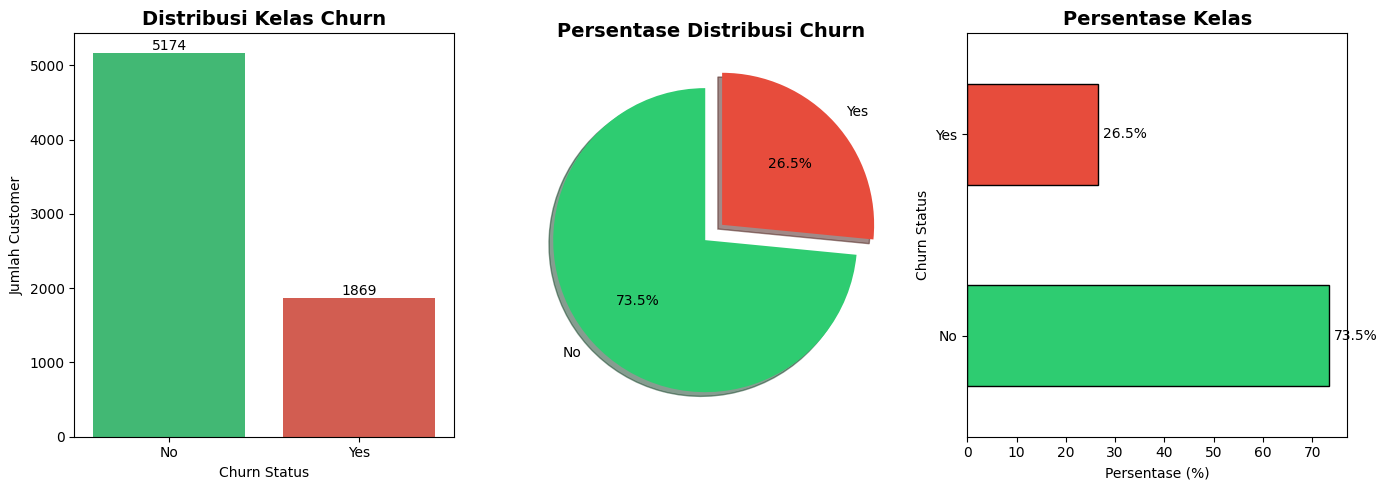


  CLASS WEIGHTS (Otomatis dihitung oleh sklearn)

Bobot untuk setiap kelas:
--------------------------------------------------
  Class 'No ': 0.6806
  Class 'Yes': 1.8842

 INTERPRETASI:
   - Model akan memberikan bobot 2.77x lebih besar
     untuk setiap kesalahan prediksi pada kelas 'Yes' (Churn)
   - Ini membuat model lebih sensitif terhadap pelanggan yang Churn
   - Recall untuk kelas Churn akan meningkat signifikan

 STRATEGI PENANGANAN IMBALANCE:
   - Metode: class_weight='balanced' (built-in sklearn)
   - Tidak ada data yang ditambah/dihapus
   - Training lebih cepat dari SMOTE/undersampling
   - Cocok untuk business objective: deteksi Churn



In [58]:
# ============================================================================
# ANALISIS IMBALANCE DATA - PENANGANAN DENGAN CLASS_WEIGHT
# ============================================================================

print("\n" + "="*80)
print(" ANALISIS IMBALANCE DATA")
print("="*80)
print("\n  Dataset churn biasanya imbalanced (lebih banyak yang tidak churn)")
print("    Kita akan menggunakan class_weight='balanced' untuk menangani ini\n")

# Hitung distribusi kelas
class_distribution = df['Churn'].value_counts()
class_percentage = df['Churn'].value_counts(normalize=True) * 100

print("Distribusi Kelas Target (Churn):")
print("-" * 50)
for cls in class_distribution.index:
    count = class_distribution[cls]
    pct = class_percentage[cls]
    print(f"  {cls:5s}: {count:5d} samples ({pct:5.2f}%)")

# Hitung rasio imbalance
majority_class = class_distribution.index[0]
minority_class = class_distribution.index[1]
imbalance_ratio = class_distribution[majority_class] / class_distribution[minority_class]

print(f"\n Rasio Imbalance: {imbalance_ratio:.2f}:1")
print(f"   Untuk setiap 1 customer '{minority_class}', ada {imbalance_ratio:.0f} customer '{majority_class}'")

# Visualisasi distribusi
plt.figure(figsize=(14, 5))

# Subplot 1: Count Plot
plt.subplot(1, 3, 1)
colors = ['#2ecc71', '#e74c3c']
ax = sns.countplot(data=df, x='Churn', palette=colors)
plt.title('Distribusi Kelas Churn', fontsize=14, fontweight='bold')
plt.ylabel('Jumlah Customer')
plt.xlabel('Churn Status')

# Tambahkan value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10)

# Subplot 2: Pie Chart
plt.subplot(1, 3, 2)
explode = (0.05, 0.1)
df['Churn'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    explode=explode,
    shadow=True
)
plt.title('Persentase Distribusi Churn', fontsize=14, fontweight='bold')
plt.ylabel('')

# Subplot 3: Bar Chart Horizontal
plt.subplot(1, 3, 3)
class_percentage.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Persentase Kelas', fontsize=14, fontweight='bold')
plt.xlabel('Persentase (%)')
plt.ylabel('Churn Status')
for i, v in enumerate(class_percentage):
    plt.text(v + 1, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

# Hitung class weight secara otomatis
classes = np.array(['No', 'Yes'])
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=df['Churn']
)
class_weights_dict = dict(zip(classes, class_weights_array))

print("\n" + "="*80)
print("  CLASS WEIGHTS (Otomatis dihitung oleh sklearn)")
print("="*80)
print("\nBobot untuk setiap kelas:")
print("-" * 50)
for cls, weight in class_weights_dict.items():
    print(f"  Class '{cls:3s}': {weight:.4f}")

weight_ratio = class_weights_dict['Yes'] / class_weights_dict['No']
print(f"\n INTERPRETASI:")
print(f"   - Model akan memberikan bobot {weight_ratio:.2f}x lebih besar")
print(f"     untuk setiap kesalahan prediksi pada kelas 'Yes' (Churn)")
print(f"   - Ini membuat model lebih sensitif terhadap pelanggan yang Churn")
print(f"   - Recall untuk kelas Churn akan meningkat signifikan")

print(f"\n STRATEGI PENANGANAN IMBALANCE:")
print(f"   - Metode: class_weight='balanced' (built-in sklearn)")
print(f"   - Tidak ada data yang ditambah/dihapus")
print(f"   - Training lebih cepat dari SMOTE/undersampling")
print(f"   - Cocok untuk business objective: deteksi Churn")

print("\n" + "="*80)

# 2. DIRECT MODELING (TANPA PREPROCESSING)

In [59]:
# ============================================================================
# 2.1. Persiapan Data untuk Direct Modeling
# ============================================================================

print("\n2.1. PERSIAPAN DATA")
print("-" * 80)

# Buat copy dataset
df_direct = df.copy()

# Convert TotalCharges ke numeric
df_direct['TotalCharges'] = pd.to_numeric(df_direct['TotalCharges'], errors='coerce')

# Drop customerID karena tidak relevan untuk prediksi
df_direct = df_direct.drop('customerID', axis=1)

# Encode semua variabel kategorikal menggunakan Label Encoding
label_encoders = {}
categorical_cols = df_direct.select_dtypes(include='object').columns

for col in categorical_cols:
    le = LabelEncoder()
    df_direct[col] = le.fit_transform(df_direct[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded kolom: {col}")

# Handle missing values dengan SimpleImputer (median untuk numerik)
imputer = SimpleImputer(strategy='median')
df_direct_imputed = pd.DataFrame(
    imputer.fit_transform(df_direct),
    columns=df_direct.columns
)

print(f"\nJumlah missing values setelah imputation: {df_direct_imputed.isnull().sum().sum()}")


2.1. PERSIAPAN DATA
--------------------------------------------------------------------------------
Encoded kolom: gender
Encoded kolom: Partner
Encoded kolom: Dependents
Encoded kolom: PhoneService
Encoded kolom: MultipleLines
Encoded kolom: InternetService
Encoded kolom: OnlineSecurity
Encoded kolom: OnlineBackup
Encoded kolom: DeviceProtection
Encoded kolom: TechSupport
Encoded kolom: StreamingTV
Encoded kolom: StreamingMovies
Encoded kolom: Contract
Encoded kolom: PaperlessBilling
Encoded kolom: PaymentMethod
Encoded kolom: Churn

Jumlah missing values setelah imputation: 0


In [60]:
# ============================================================================
# 2.2. Train-Test Split
# ============================================================================

print("\n2.2. TRAIN-TEST SPLIT")
print("-" * 80)

# Pisahkan fitur dan target
X_direct = df_direct_imputed.drop('Churn', axis=1)
y_direct = df_direct_imputed['Churn']

# Split data (80% train, 20% test)
X_train_direct, X_test_direct, y_train_direct, y_test_direct = train_test_split(
    X_direct, y_direct, test_size=0.2, random_state=42, stratify=y_direct
)

print(f"Jumlah data training: {len(X_train_direct)}")
print(f"Jumlah data testing: {len(X_test_direct)}")
print(f"\nDistribusi target di data training:")
print(y_train_direct.value_counts())
print(f"\nDistribusi target di data testing:")
print(y_test_direct.value_counts())



2.2. TRAIN-TEST SPLIT
--------------------------------------------------------------------------------
Jumlah data training: 5634
Jumlah data testing: 1409

Distribusi target di data training:
Churn
0.0    4139
1.0    1495
Name: count, dtype: int64

Distribusi target di data testing:
Churn
0.0    1035
1.0     374
Name: count, dtype: int64


In [61]:
# ============================================================================
# 2.3. Inisialisasi Model
# ============================================================================

print("\n2.3. INISIALISASI MODEL")
print("-" * 80)

# Model 1: Logistic Regression (Konvensional)
model_lr_direct = LogisticRegression(random_state=42, max_iter=1000)
print("Model 1: Logistic Regression (Konvensional)")

# Model 2: Random Forest (Ensemble Bagging)
model_rf_direct = RandomForestClassifier(random_state=42)
print("Model 2: Random Forest (Ensemble Bagging)")

# Model 3: Voting Classifier (Ensemble Voting)
# Gabungan Logistic Regression, SVM, dan KNN
voting_estimators = [
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('svm', SVC(random_state=42, probability=True)),
    ('knn', KNeighborsClassifier())
]
model_voting_direct = VotingClassifier(estimators=voting_estimators, voting='soft')
print("Model 3: Voting Classifier (Ensemble Voting: LR + SVM + KNN)")


2.3. INISIALISASI MODEL
--------------------------------------------------------------------------------
Model 1: Logistic Regression (Konvensional)
Model 2: Random Forest (Ensemble Bagging)
Model 3: Voting Classifier (Ensemble Voting: LR + SVM + KNN)


In [62]:
# ============================================================================
# 2.4. Training Model
# ============================================================================

print("\n2.4. TRAINING MODEL")
print("-" * 80)

# Dictionary untuk menyimpan model
models_direct = {
    'Logistic Regression': model_lr_direct,
    'Random Forest': model_rf_direct,
    'Voting Classifier': model_voting_direct
}

# Training semua model
for name, model in models_direct.items():
    print(f"\nMelatih model: {name}...")
    model.fit(X_train_direct, y_train_direct)
    print(f"Model {name} berhasil dilatih!")


2.4. TRAINING MODEL
--------------------------------------------------------------------------------

Melatih model: Logistic Regression...
Model Logistic Regression berhasil dilatih!

Melatih model: Random Forest...
Model Random Forest berhasil dilatih!

Melatih model: Voting Classifier...
Model Voting Classifier berhasil dilatih!



2.5. EVALUASI MODEL DIRECT MODELING
--------------------------------------------------------------------------------

HASIL EVALUASI: Logistic Regression
Accuracy  : 0.7999
Precision : 0.6420
Recall    : 0.5561
F1-Score  : 0.5960

Confusion Matrix:
[[919 116]
 [166 208]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1035
       Churn       0.64      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



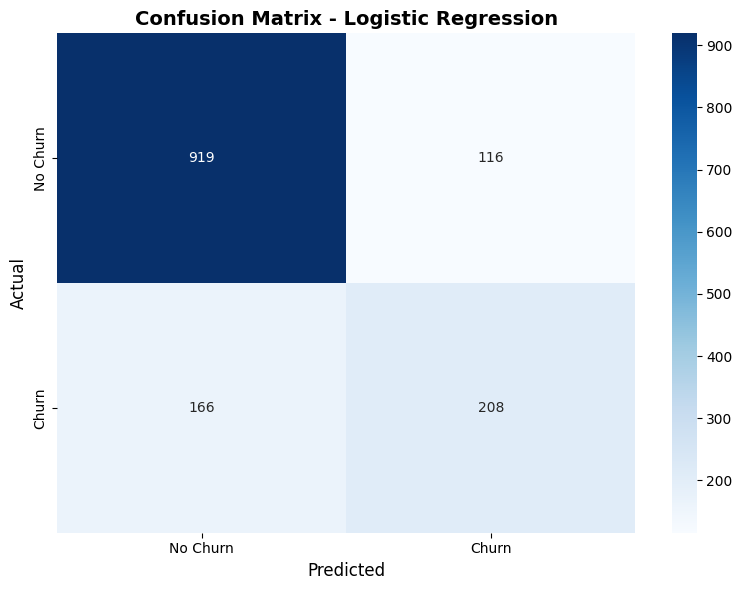


HASIL EVALUASI: Random Forest
Accuracy  : 0.7921
Precision : 0.6373
Recall    : 0.5027
F1-Score  : 0.5620

Confusion Matrix:
[[928 107]
 [186 188]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86      1035
       Churn       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



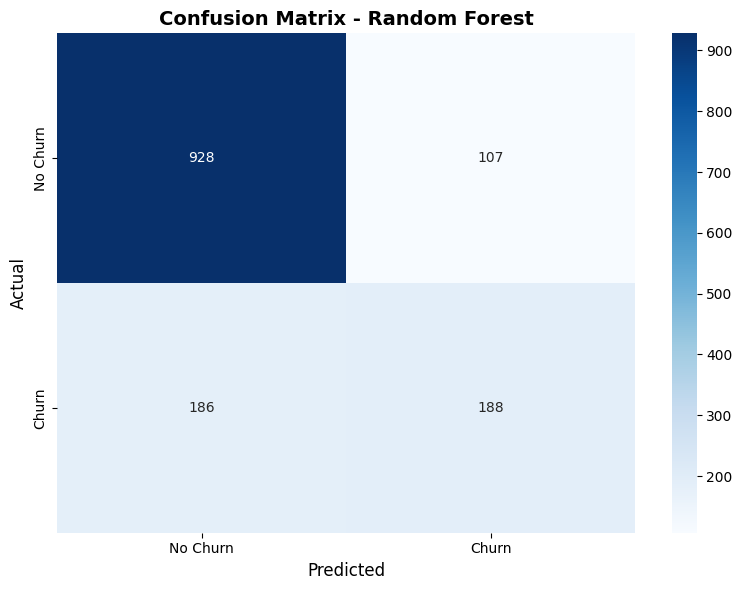


HASIL EVALUASI: Voting Classifier
Accuracy  : 0.7963
Precision : 0.6761
Recall    : 0.4465
F1-Score  : 0.5378

Confusion Matrix:
[[955  80]
 [207 167]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.82      0.92      0.87      1035
       Churn       0.68      0.45      0.54       374

    accuracy                           0.80      1409
   macro avg       0.75      0.68      0.70      1409
weighted avg       0.78      0.80      0.78      1409



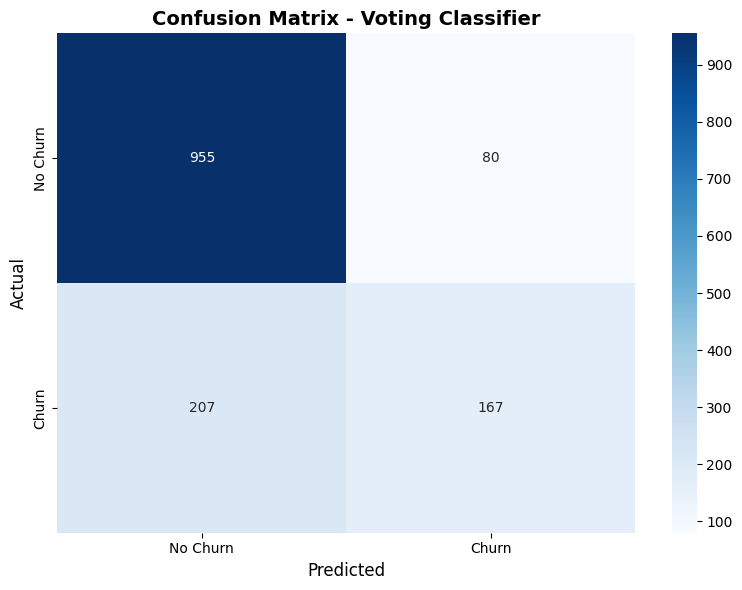

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix,
                             classification_report)

# ============================================================================
# 2.5. Evaluasi Model
# ============================================================================

print("\n2.5. EVALUASI MODEL DIRECT MODELING")
print("-" * 80)

# Fungsi untuk evaluasi model
def evaluate_model(model, X_test, y_test, model_name):
    """
    Fungsi untuk mengevaluasi performa model
    """
    # Prediksi
    y_pred = model.predict(X_test)

    # Determine pos_label based on y_test type
    if y_test.dtype == 'object':
        # Assuming 'Yes' is the positive class for string labels
        pos_label_value = 'Yes'
        target_names_values = ['No', 'Yes'] # For classification report labels
    else:
        # Assuming 1 is the positive class for numerical labels
        pos_label_value = 1
        target_names_values = ['No Churn', 'Churn'] # For classification report labels

    # Hitung metrik
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=pos_label_value)
    recall = recall_score(y_test, y_pred, pos_label=pos_label_value)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label_value)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=target_names_values if y_test.dtype == 'object' else None)

    # Print hasil
    print(f"\n{'='*60}")
    print(f"HASIL EVALUASI: {model_name}")
    print(f"{'='*60}")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-Score  : {f1:.4f}")

    print(f"\nConfusion Matrix:")
    print(cm)

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names_values))

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=target_names_values,
                yticklabels=target_names_values)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# Evaluasi semua model
results_direct = {}
for name, model in models_direct.items():
    results_direct[name] = evaluate_model(model, X_test_direct, y_test_direct, name)



2.6. PERBANDINGAN PERFORMA MODEL DIRECT MODELING
--------------------------------------------------------------------------------

Tabel Perbandingan Performa:
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.799858   0.641975 0.556150  0.595989
      Random Forest  0.792051   0.637288 0.502674  0.562033
  Voting Classifier  0.796309   0.676113 0.446524  0.537842


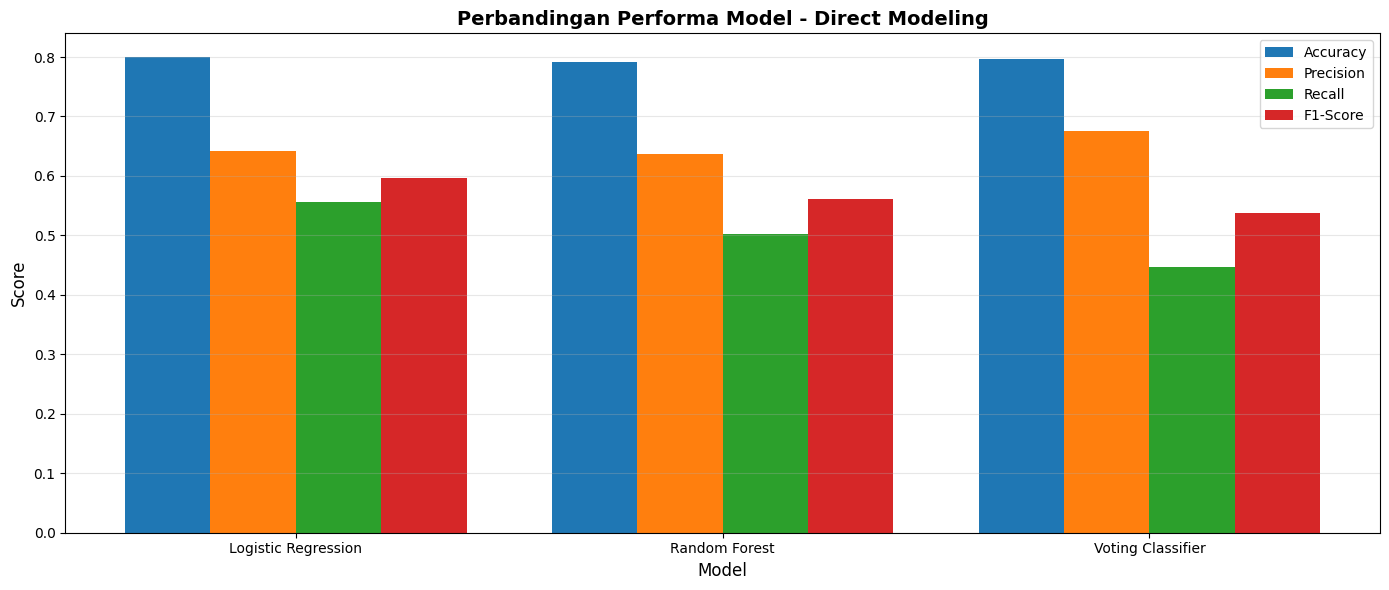


Model terbaik (Direct Modeling): Logistic Regression

Direct Modeling selesai!


In [64]:
# ============================================================================
# 2.6. Perbandingan Performa Model
# ============================================================================

print("\n2.6. PERBANDINGAN PERFORMA MODEL DIRECT MODELING")
print("-" * 80)

# Buat DataFrame untuk perbandingan
comparison_direct = pd.DataFrame({
    'Model': list(results_direct.keys()),
    'Accuracy': [results_direct[m]['accuracy'] for m in results_direct.keys()],
    'Precision': [results_direct[m]['precision'] for m in results_direct.keys()],
    'Recall': [results_direct[m]['recall'] for m in results_direct.keys()],
    'F1-Score': [results_direct[m]['f1_score'] for m in results_direct.keys()]
})

print("\nTabel Perbandingan Performa:")
print(comparison_direct.to_string(index=False))

# Visualisasi perbandingan
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_direct))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 6))

for i, metric in enumerate(metrics):
    offset = width * (i - 1.5)
    ax.bar(x + offset, comparison_direct[metric], width, label=metric)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Perbandingan Performa Model - Direct Modeling', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_direct['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Identifikasi model terbaik berdasarkan F1-Score
best_model_direct = comparison_direct.loc[comparison_direct['F1-Score'].idxmax(), 'Model']
print(f"\nModel terbaik (Direct Modeling): {best_model_direct}")

print("\nDirect Modeling selesai!")

In [65]:
# ============================================================================
# 2. MODELING DIRECT (DENGAN CLASS_WEIGHT='BALANCED')
# ============================================================================

print("\n" + "="*80)
print("2. MODELING DIRECT (DENGAN PENANGANAN IMBALANCE)")
print("="*80)
print("\n Menggunakan class_weight='balanced' untuk semua model")

# Pisahkan fitur dan target
X_direct = df.drop(['Churn', 'customerID'], axis=1)
y_direct = df['Churn']

# Label encoding untuk semua fitur kategorikal
print("\n Melakukan Label Encoding untuk fitur kategorikal...")
label_encoders_direct = {}

for column in X_direct.columns:
    if X_direct[column].dtype == 'object':
        le = LabelEncoder()
        X_direct[column] = le.fit_transform(X_direct[column])
        label_encoders_direct[column] = le
        print(f"  ✓ {column}")

# Split data dengan stratify
X_train_direct, X_test_direct, y_train_direct, y_test_direct = train_test_split(
    X_direct, y_direct, test_size=0.2, random_state=42, stratify=y_direct
)

print(f"\n Data Split:")
print(f"   Training: {X_train_direct.shape[0]} samples")
print(f"   Testing:  {X_test_direct.shape[0]} samples")


2. MODELING DIRECT (DENGAN PENANGANAN IMBALANCE)

 Menggunakan class_weight='balanced' untuk semua model

 Melakukan Label Encoding untuk fitur kategorikal...
  ✓ gender
  ✓ Partner
  ✓ Dependents
  ✓ PhoneService
  ✓ MultipleLines
  ✓ InternetService
  ✓ OnlineSecurity
  ✓ OnlineBackup
  ✓ DeviceProtection
  ✓ TechSupport
  ✓ StreamingTV
  ✓ StreamingMovies
  ✓ Contract
  ✓ PaperlessBilling
  ✓ PaymentMethod
  ✓ TotalCharges

 Data Split:
   Training: 5634 samples
   Testing:  1409 samples


In [68]:
# ---- PERUBAHAN UTAMA: TAMBAH class_weight='balanced' ----
print("\n" + "-"*80)
print(" TRAINING MODELS DENGAN CLASS_WEIGHT='BALANCED'")
print("-"*80)

models_direct = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'  # ← PENANGANAN IMBALANCE
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'  # ← PENANGANAN IMBALANCE
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=5
        # KNN tidak mendukung class_weight
    ),
    'SVM': SVC(
        kernel='rbf',
        random_state=42,
        class_weight='balanced'  # ← PENANGANAN IMBALANCE
    )
}

# Training dan evaluasi
results_direct = {}

for name, model in models_direct.items():
    print(f"\n{'='*70}")
    print(f" Training: {name}")
    print(f"{'='*70}")

    # Check class_weight support
    has_cw = hasattr(model, 'class_weight') and name != 'KNN'
    cw_status = " class_weight='balanced'" if has_cw else " No class_weight support"
    print(f"Status: {cw_status}")

    # Training
    print(" Training model...")
    model.fit(X_train_direct, y_train_direct)

    # Prediksi
    y_pred = model.predict(X_test_direct)

    # Evaluasi
    acc = accuracy_score(y_test_direct, y_pred)
    prec = precision_score(y_test_direct, y_pred, pos_label='Yes')
    rec = recall_score(y_test_direct, y_pred, pos_label='Yes')
    f1 = f1_score(y_test_direct, y_pred, pos_label='Yes')

    results_direct[name] = {
        'model': model,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'has_class_weight': has_cw
    }

    print(f"\n Hasil Evaluasi:")
    print(f"   Accuracy  : {acc:.4f}")
    print(f"   Precision : {prec:.4f}")
    print(f"   Recall    : {rec:.4f} ")
    print(f"   F1-Score  : {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_direct, y_pred, labels=['No', 'Yes'])
    print(f"\n   Confusion Matrix:")
    print(f"                Predicted No  Predicted Yes")
    print(f"   Actual No    {cm[0,0]:>12d}  {cm[0,1]:>13d}")
    print(f"   Actual Yes   {cm[1,0]:>12d}  {cm[1,1]:>13d}")


--------------------------------------------------------------------------------
 TRAINING MODELS DENGAN CLASS_WEIGHT='BALANCED'
--------------------------------------------------------------------------------

 Training: Logistic Regression
Status:  class_weight='balanced'
 Training model...

 Hasil Evaluasi:
   Accuracy  : 0.7424
   Precision : 0.5095
   Recall    : 0.7914 
   F1-Score  : 0.6199

   Confusion Matrix:
                Predicted No  Predicted Yes
   Actual No             750            285
   Actual Yes             78            296

 Training: Random Forest
Status:  class_weight='balanced'
 Training model...

 Hasil Evaluasi:
   Accuracy  : 0.7871
   Precision : 0.6360
   Recall    : 0.4626 
   F1-Score  : 0.5356

   Confusion Matrix:
                Predicted No  Predicted Yes
   Actual No             936             99
   Actual Yes            201            173

 Training: KNN
Status:  No class_weight support
 Training model...

 Hasil Evaluasi:
   Accuracy  : 0.74

In [69]:
# Perbandingan hasil
print("\n" + "="*80)
print(" PERBANDINGAN HASIL MODEL DIRECT")
print("="*80)

comparison_df_direct = pd.DataFrame({
    'Model': list(results_direct.keys()),
    'Accuracy': [results_direct[m]['accuracy'] for m in results_direct],
    'Precision': [results_direct[m]['precision'] for m in results_direct],
    'Recall': [results_direct[m]['recall'] for m in results_direct],
    'F1-Score': [results_direct[m]['f1_score'] for m in results_direct],
    'Class Weight': [results_direct[m]['has_class_weight'] for m in results_direct]
})

comparison_df_direct = comparison_df_direct.sort_values('F1-Score', ascending=False)
print("\n", comparison_df_direct.to_string(index=False))

best_model_direct = comparison_df_direct.iloc[0]['Model']
best_f1_direct = comparison_df_direct.iloc[0]['F1-Score']
print(f"\n Model terbaik (Direct): {best_model_direct}")
print(f"   F1-Score: {best_f1_direct:.4f}")
print(f"   Recall: {comparison_df_direct.iloc[0]['Recall']:.4f}")

print("\n Direct Modeling selesai!")


 PERBANDINGAN HASIL MODEL DIRECT

               Model  Accuracy  Precision   Recall  F1-Score  Class Weight
Logistic Regression  0.742370   0.509466 0.791444  0.619895          True
      Random Forest  0.787083   0.636029 0.462567  0.535604          True
                SVM  0.581973   0.351724 0.681818  0.464058          True
                KNN  0.743790   0.523985 0.379679  0.440310         False

 Model terbaik (Direct): Logistic Regression
   F1-Score: 0.6199
   Recall: 0.7914

 Direct Modeling selesai!


In [28]:
# Perbandingan hasil (sama seperti original)
print("\n" + "="*80)
print("PERBANDINGAN HASIL MODEL DIRECT")
print("="*80)

results_df_direct = pd.DataFrame({
    'Model': list(results_direct.keys()),
    'Accuracy': [results_direct[m]['accuracy'] for m in results_direct],
    'Precision': [results_direct[m]['precision'] for m in results_direct],
    'Recall': [results_direct[m]['recall'] for m in results_direct],
    'F1-Score': [results_direct[m]['f1_score'] for m in results_direct]
})

results_df_direct = results_df_direct.sort_values('F1-Score', ascending=False)
print("\n", results_df_direct.to_string(index=False))

# Model terbaik
best_model_direct = results_df_direct.iloc[0]['Model']
print(f"\n Model terbaik (Direct): {best_model_direct}")
print(f"   F1-Score: {results_df_direct.iloc[0]['F1-Score']:.4f}")

print("\n Direct Modeling selesai!")


PERBANDINGAN HASIL MODEL DIRECT

               Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.742370   0.509466 0.791444  0.619895
      Random Forest  0.787083   0.636029 0.462567  0.535604
                SVM  0.581973   0.351724 0.681818  0.464058
                KNN  0.743790   0.523985 0.379679  0.440310

 Model terbaik (Direct): Logistic Regression
   F1-Score: 0.6199

 Direct Modeling selesai!


# 3. MODELING DENGAN PREPROCESSING

In [70]:
# ============================================================================
# 3.1. Data Preprocessing
# ============================================================================

print("\n3.1. DATA PREPROCESSING")
print("-" * 80)

# Buat copy dataset
df_prep = df.copy()

print("Langkah 1: Menangani Missing Values")
print("-" * 40)

# Convert TotalCharges ke numeric
df_prep['TotalCharges'] = pd.to_numeric(df_prep['TotalCharges'], errors='coerce')
print(f"TotalCharges dikonversi ke numeric")
print(f"Jumlah missing values di TotalCharges: {df_prep['TotalCharges'].isnull().sum()}")

# Isi missing values di TotalCharges dengan 0 (asumsi: pelanggan baru belum bayar)
df_prep['TotalCharges'].fillna(0, inplace=True)
print(f"Missing values di TotalCharges diisi dengan 0")

print("\nLangkah 2: Menangani Duplikasi")
print("-" * 40)

# Cek duplikasi
duplicates = df_prep.duplicated().sum()
print(f"Jumlah baris duplikat: {duplicates}")

if duplicates > 0:
    df_prep = df_prep.drop_duplicates()
    print(f"Duplikasi telah dihapus")
else:
    print("Tidak ada duplikasi dalam dataset")

print("\nLangkah 3: Menangani Outlier")
print("-" * 40)

# Identifikasi outlier menggunakan IQR untuk kolom numerik
numeric_cols_for_outlier = ['tenure', 'MonthlyCharges', 'TotalCharges']

def detect_outliers_iqr(df, column):
    """
    Deteksi outlier menggunakan metode IQR
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

print("\nDeteksi Outlier:")
for col in numeric_cols_for_outlier:
    n_outliers, lower, upper = detect_outliers_iqr(df_prep, col)
    print(f"  - {col}: {n_outliers} outliers (batas: {lower:.2f} - {upper:.2f})")

# Untuk kasus ini, kita tidak menghapus outlier karena bisa jadi merupakan pola valid
# (misalnya pelanggan dengan biaya tinggi atau tenure panjang)
print("\nKeputusan: Outlier tidak dihapus karena merupakan pola bisnis yang valid")

print("\nLangkah 4: Drop Kolom Tidak Relevan")
print("-" * 40)

# Drop customerID karena tidak relevan untuk prediksi
df_prep = df_prep.drop('customerID', axis=1)
print("Kolom 'customerID' telah dihapus")

print("\nLangkah 5: Encoding Variabel Kategorikal")
print("-" * 40)

# Identifikasi kolom kategorikal (kecuali target)
categorical_cols_prep = df_prep.select_dtypes(include='object').columns.tolist()
categorical_cols_prep.remove('Churn')  # Exclude target

print(f"Kolom kategorikal yang akan di-encode: {len(categorical_cols_prep)} kolom")

# Gunakan Label Encoding untuk semua variabel kategorikal
label_encoders_prep = {}
for col in categorical_cols_prep:
    le = LabelEncoder()
    df_prep[col] = le.fit_transform(df_prep[col])
    label_encoders_prep[col] = le
    print(f"  - Encoded: {col}")

# Encode target variable
le_target = LabelEncoder()
df_prep['Churn'] = le_target.fit_transform(df_prep['Churn'])
print(f"  - Encoded: Churn (target)")

print("\nLangkah 6: Feature Scaling")
print("-" * 40)

# Pisahkan fitur dan target terlebih dahulu
X_prep = df_prep.drop('Churn', axis=1)
y_prep = df_prep['Churn']

# Identifikasi kolom yang perlu di-scaling (numerik dengan skala berbeda)
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Gunakan StandardScaler
scaler = StandardScaler()
X_prep[cols_to_scale] = scaler.fit_transform(X_prep[cols_to_scale])

print(f"Kolom yang di-scaling: {cols_to_scale}")
print("Scaling menggunakan StandardScaler")

print("\nPreprocessing selesai!")
print(f"Jumlah sampel setelah preprocessing: {len(df_prep)}")
print(f"Jumlah fitur setelah preprocessing: {X_prep.shape[1]}")


3.1. DATA PREPROCESSING
--------------------------------------------------------------------------------
Langkah 1: Menangani Missing Values
----------------------------------------
TotalCharges dikonversi ke numeric
Jumlah missing values di TotalCharges: 11
Missing values di TotalCharges diisi dengan 0

Langkah 2: Menangani Duplikasi
----------------------------------------
Jumlah baris duplikat: 0
Tidak ada duplikasi dalam dataset

Langkah 3: Menangani Outlier
----------------------------------------

Deteksi Outlier:
  - tenure: 0 outliers (batas: -60.00 - 124.00)
  - MonthlyCharges: 0 outliers (batas: -46.02 - 171.38)
  - TotalCharges: 0 outliers (batas: -4683.52 - 8868.67)

Keputusan: Outlier tidak dihapus karena merupakan pola bisnis yang valid

Langkah 4: Drop Kolom Tidak Relevan
----------------------------------------
Kolom 'customerID' telah dihapus

Langkah 5: Encoding Variabel Kategorikal
----------------------------------------
Kolom kategorikal yang akan di-encode: 15 ko

In [71]:
# ============================================================================
# 3.2. Train-Test Split
# ============================================================================

print("\n3.2. TRAIN-TEST SPLIT")
print("-" * 80)

# Split data (80% train, 20% test) dengan stratify
X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(
    X_prep, y_prep, test_size=0.2, random_state=42, stratify=y_prep
)

print(f"Jumlah data training: {len(X_train_prep)}")
print(f"Jumlah data testing: {len(X_test_prep)}")
print(f"\nDistribusi target di data training:")
print(y_train_prep.value_counts())
print(f"\nDistribusi target di data testing:")
print(y_test_prep.value_counts())


3.2. TRAIN-TEST SPLIT
--------------------------------------------------------------------------------
Jumlah data training: 5634
Jumlah data testing: 1409

Distribusi target di data training:
Churn
0    4139
1    1495
Name: count, dtype: int64

Distribusi target di data testing:
Churn
0    1035
1     374
Name: count, dtype: int64


In [72]:
# ============================================================================
# 3.3. Inisialisasi dan Training Model
# ============================================================================

print("\n3.3. INISIALISASI DAN TRAINING MODEL")
print("-" * 80)

# Inisialisasi model yang sama dengan Direct Modeling
model_lr_prep = LogisticRegression(random_state=42, max_iter=1000)
model_rf_prep = RandomForestClassifier(random_state=42)

voting_estimators_prep = [
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('svm', SVC(random_state=42, probability=True)),
    ('knn', KNeighborsClassifier())
]
model_voting_prep = VotingClassifier(estimators=voting_estimators_prep, voting='soft')

# Dictionary untuk menyimpan model
models_prep = {
    'Logistic Regression': model_lr_prep,
    'Random Forest': model_rf_prep,
    'Voting Classifier': model_voting_prep
}

# Training semua model
for name, model in models_prep.items():
    print(f"\nMelatih model: {name}...")
    model.fit(X_train_prep, y_train_prep)
    print(f"Model {name} berhasil dilatih!")


3.3. INISIALISASI DAN TRAINING MODEL
--------------------------------------------------------------------------------

Melatih model: Logistic Regression...
Model Logistic Regression berhasil dilatih!

Melatih model: Random Forest...
Model Random Forest berhasil dilatih!

Melatih model: Voting Classifier...
Model Voting Classifier berhasil dilatih!



3.4. EVALUASI MODEL DENGAN PREPROCESSING
--------------------------------------------------------------------------------

HASIL EVALUASI: Logistic Regression
Accuracy  : 0.7999
Precision : 0.6447
Recall    : 0.5481
F1-Score  : 0.5925

Confusion Matrix:
[[922 113]
 [169 205]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1035
       Churn       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



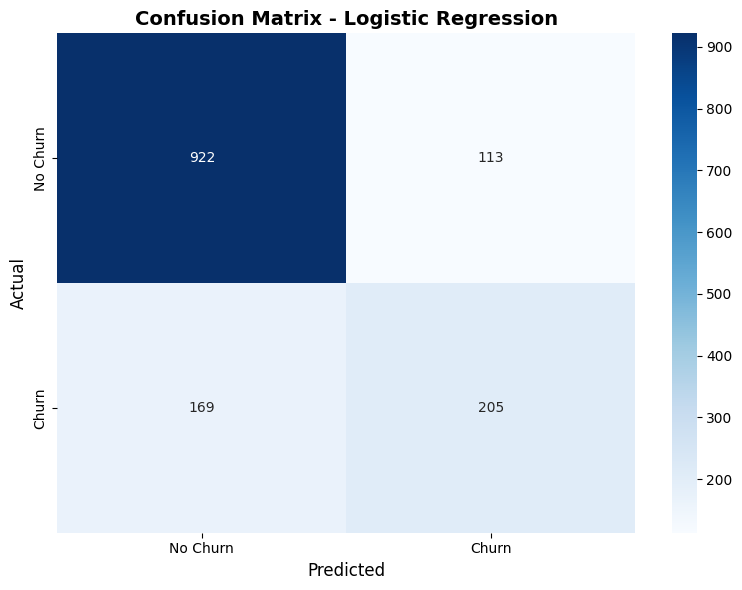


HASIL EVALUASI: Random Forest
Accuracy  : 0.7935
Precision : 0.6388
Recall    : 0.5107
F1-Score  : 0.5676

Confusion Matrix:
[[927 108]
 [183 191]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.86      1035
       Churn       0.64      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.79      1409



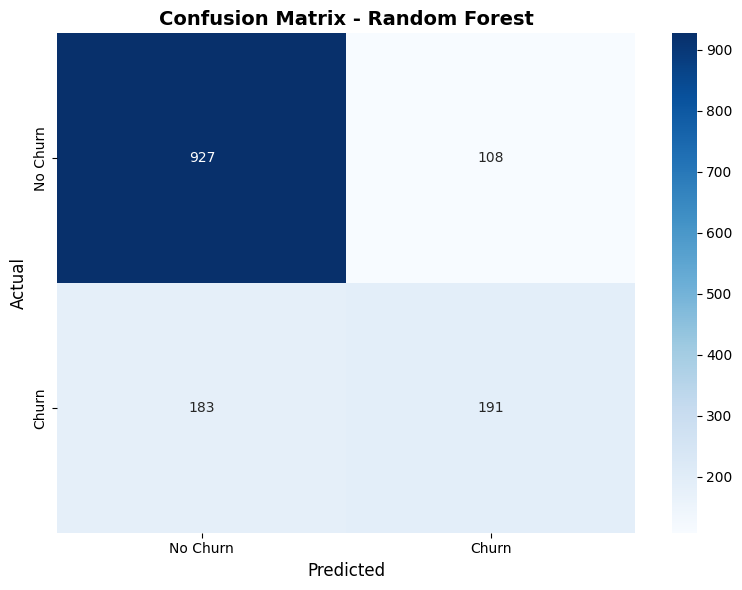


HASIL EVALUASI: Voting Classifier
Accuracy  : 0.7899
Precision : 0.6393
Recall    : 0.4786
F1-Score  : 0.5474

Confusion Matrix:
[[934 101]
 [195 179]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86      1035
       Churn       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



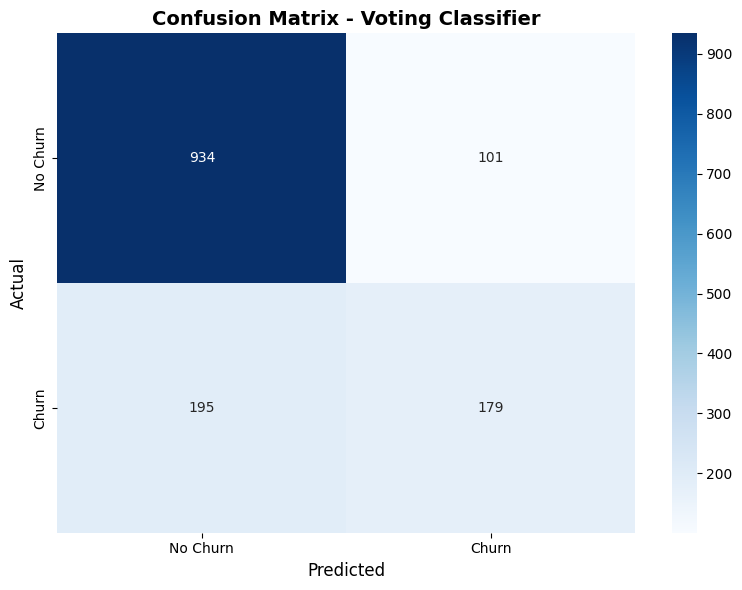

In [73]:
# ============================================================================
# 3.4. Evaluasi Model
# ============================================================================

print("\n3.4. EVALUASI MODEL DENGAN PREPROCESSING")
print("-" * 80)

# Evaluasi semua model
results_prep = {}
for name, model in models_prep.items():
    results_prep[name] = evaluate_model(model, X_test_prep, y_test_prep, name)



3.5. PERBANDINGAN PERFORMA MODEL DENGAN PREPROCESSING
--------------------------------------------------------------------------------

Tabel Perbandingan Performa:
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.799858   0.644654 0.548128  0.592486
      Random Forest  0.793471   0.638796 0.510695  0.567608
  Voting Classifier  0.789922   0.639286 0.478610  0.547401


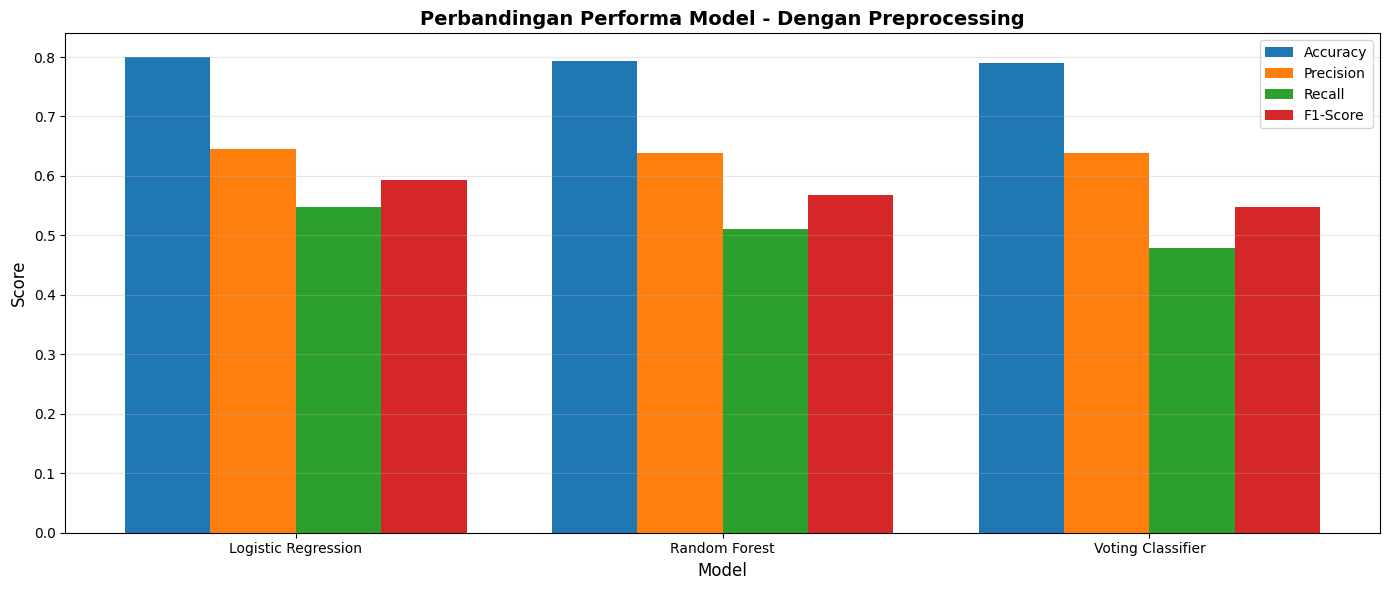


Model terbaik (Dengan Preprocessing): Logistic Regression


In [74]:
# ============================================================================
# 3.5. Perbandingan Performa Model
# ============================================================================

print("\n3.5. PERBANDINGAN PERFORMA MODEL DENGAN PREPROCESSING")
print("-" * 80)

# Buat DataFrame untuk perbandingan
comparison_prep = pd.DataFrame({
    'Model': list(results_prep.keys()),
    'Accuracy': [results_prep[m]['accuracy'] for m in results_prep.keys()],
    'Precision': [results_prep[m]['precision'] for m in results_prep.keys()],
    'Recall': [results_prep[m]['recall'] for m in results_prep.keys()],
    'F1-Score': [results_prep[m]['f1_score'] for m in results_prep.keys()]
})

print("\nTabel Perbandingan Performa:")
print(comparison_prep.to_string(index=False))

# Visualisasi perbandingan
fig, ax = plt.subplots(figsize=(14, 6))

for i, metric in enumerate(metrics):
    offset = width * (i - 1.5)
    ax.bar(x + offset, comparison_prep[metric], width, label=metric)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Perbandingan Performa Model - Dengan Preprocessing', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_prep['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Identifikasi model terbaik
best_model_prep = comparison_prep.loc[comparison_prep['F1-Score'].idxmax(), 'Model']
print(f"\nModel terbaik (Dengan Preprocessing): {best_model_prep}")



3.6. PERBANDINGAN: DIRECT MODELING VS PREPROCESSING
--------------------------------------------------------------------------------

Perbandingan Lengkap:
              Model  Accuracy  Precision   Recall  F1-Score      Skenario
Logistic Regression  0.799858   0.641975 0.556150  0.595989        Direct
      Random Forest  0.792051   0.637288 0.502674  0.562033        Direct
  Voting Classifier  0.796309   0.676113 0.446524  0.537842        Direct
Logistic Regression  0.799858   0.644654 0.548128  0.592486 Preprocessing
      Random Forest  0.793471   0.638796 0.510695  0.567608 Preprocessing
  Voting Classifier  0.789922   0.639286 0.478610  0.547401 Preprocessing


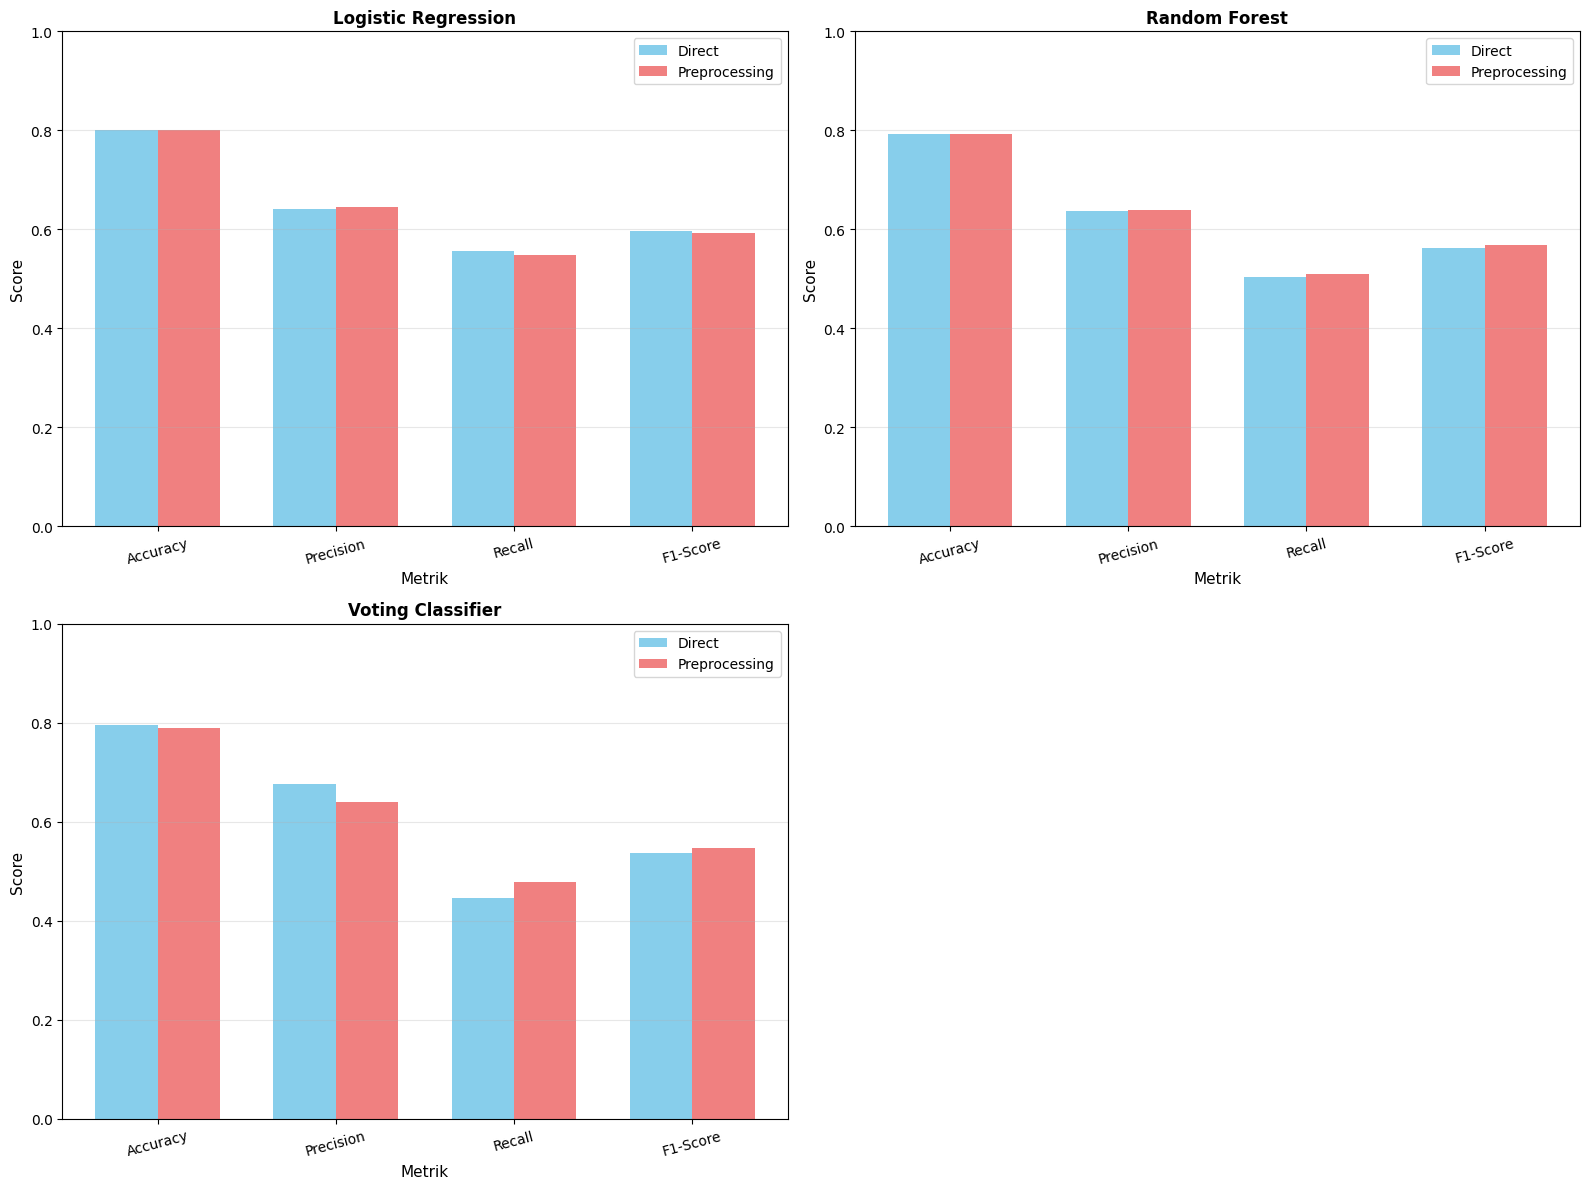


Modeling dengan Preprocessing selesai!


In [75]:
# ============================================================================
# 3.6. Perbandingan Direct vs Preprocessing
# ============================================================================

print("\n3.6. PERBANDINGAN: DIRECT MODELING VS PREPROCESSING")
print("-" * 80)

# Gabungkan hasil
comparison_direct['Skenario'] = 'Direct'
comparison_prep['Skenario'] = 'Preprocessing'
comparison_all = pd.concat([comparison_direct, comparison_prep])

print("\nPerbandingan Lengkap:")
print(comparison_all.to_string(index=False))

# Visualisasi perbandingan untuk setiap model
models_list = comparison_direct['Model'].unique()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, model_name in enumerate(models_list):
    model_data = comparison_all[comparison_all['Model'] == model_name]

    x_pos = np.arange(len(metrics))
    width = 0.35

    direct_scores = model_data[model_data['Skenario'] == 'Direct'][metrics].values[0]
    prep_scores = model_data[model_data['Skenario'] == 'Preprocessing'][metrics].values[0]

    axes[idx].bar(x_pos - width/2, direct_scores, width, label='Direct', color='skyblue')
    axes[idx].bar(x_pos + width/2, prep_scores, width, label='Preprocessing', color='lightcoral')

    axes[idx].set_xlabel('Metrik', fontsize=11)
    axes[idx].set_ylabel('Score', fontsize=11)
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(metrics, rotation=15)
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0, 1])

# Hapus subplot keempat jika hanya ada 3 model
if len(models_list) < 4:
    fig.delaxes(axes[3])

plt.tight_layout()
plt.show()

print("\nModeling dengan Preprocessing selesai!")

#Modeling Preprocessing (Update Dengan class_weight)

In [76]:
# ============================================================================
# 3. MODELING DENGAN PREPROCESSING (DENGAN CLASS_WEIGHT='BALANCED')
# ============================================================================

print("\n" + "="*80)
print("3. MODELING PREPROCESSING (DENGAN PENANGANAN IMBALANCE)")
print("="*80)
print("\n Preprocessing + class_weight='balanced'")

# 3.1. Data Preprocessing
print("\n3.1. DATA PREPROCESSING")
print("-" * 80)

df_prep = df.copy()

print("Langkah 1: Menangani Missing Values")
print("-" * 40)

# Convert TotalCharges ke numeric
df_prep['TotalCharges'] = pd.to_numeric(df_prep['TotalCharges'], errors='coerce')
missing_count = df_prep['TotalCharges'].isnull().sum()
print(f" TotalCharges dikonversi ke numeric")
print(f"  Jumlah missing values: {missing_count}")

# Isi missing values dengan 0
df_prep['TotalCharges'].fillna(0, inplace=True)
print(f" Missing values diisi dengan 0")

print("\nLangkah 2: Encoding Fitur Kategorikal")
print("-" * 40)

# Pisahkan fitur dan target
X_prep = df_prep.drop(['Churn', 'customerID'], axis=1)
y_prep = df_prep['Churn']

# Identifikasi tipe kolom
nominal_cols = ['InternetService', 'Contract', 'PaymentMethod']
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
               'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV',
               'StreamingMovies', 'PaperlessBilling']

# Label Encoding
label_encoders_prep = {}

print("\nLabel Encoding untuk fitur nominal:")
for col in nominal_cols:
    le = LabelEncoder()
    X_prep[col] = le.fit_transform(X_prep[col])
    label_encoders_prep[col] = le
    print(f"   {col}")

print("\nLabel Encoding untuk fitur binary:")
for col in binary_cols:
    le = LabelEncoder()
    X_prep[col] = le.fit_transform(X_prep[col])
    label_encoders_prep[col] = le
    print(f"   {col}")

# Scaling fitur numerik
print("\nLangkah 3: Feature Scaling")
print("-" * 40)

scaler = StandardScaler()
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

X_prep[numeric_cols] = scaler.fit_transform(X_prep[numeric_cols])
print(f" Fitur numerik telah di-scale: {numeric_cols}")

# Split data dengan stratify
X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(
    X_prep, y_prep, test_size=0.2, random_state=42, stratify=y_prep
)

print(f"\n Data Split:")
print(f"   Training: {X_train_prep.shape[0]} samples")
print(f"   Testing:  {X_test_prep.shape[0]} samples")


3. MODELING PREPROCESSING (DENGAN PENANGANAN IMBALANCE)

 Preprocessing + class_weight='balanced'

3.1. DATA PREPROCESSING
--------------------------------------------------------------------------------
Langkah 1: Menangani Missing Values
----------------------------------------
 TotalCharges dikonversi ke numeric
  Jumlah missing values: 11
 Missing values diisi dengan 0

Langkah 2: Encoding Fitur Kategorikal
----------------------------------------

Label Encoding untuk fitur nominal:
   InternetService
   Contract
   PaymentMethod

Label Encoding untuk fitur binary:
   gender
   Partner
   Dependents
   PhoneService
   MultipleLines
   OnlineSecurity
   OnlineBackup
   DeviceProtection
   TechSupport
   StreamingTV
   StreamingMovies
   PaperlessBilling

Langkah 3: Feature Scaling
----------------------------------------
 Fitur numerik telah di-scale: ['tenure', 'MonthlyCharges', 'TotalCharges']

 Data Split:
   Training: 5634 samples
   Testing:  1409 samples


In [79]:
print("\n" + "-"*80)
print(" TRAINING MODELS DENGAN PREPROCESSING & CLASS_WEIGHT='BALANCED'")
print("-"*80)

models_prep = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'  # ← PENANGANAN IMBALANCE
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'  # ← PENANGANAN IMBALANCE
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=5
        # KNN tidak mendukung class_weight
    ),
    'SVM': SVC(
        kernel='rbf',
        random_state=42,
        class_weight='balanced'  # ← PENANGANAN IMBALANCE
    )
}

# Training dan evaluasi
results_prep = {}

for name, model in models_prep.items():
    print(f"\n{'='*70}")
    print(f" Training: {name}")
    print(f"{'='*70}")

    # Check class_weight support
    has_cw = hasattr(model, 'class_weight') and name != 'KNN'
    cw_status = " class_weight='balanced'" if has_cw else " No class_weight support"
    print(f"Status: {cw_status}")

    # Training
    print(" Training model...")
    model.fit(X_train_prep, y_train_prep)

    # Prediksi
    y_pred = model.predict(X_test_prep)

    # Evaluasi
    acc = accuracy_score(y_test_prep, y_pred)
    prec = precision_score(y_test_prep, y_pred, pos_label='Yes')
    rec = recall_score(y_test_prep, y_pred, pos_label='Yes')
    f1 = f1_score(y_test_prep, y_pred, pos_label='Yes')

    results_prep[name] = {
        'model': model,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'has_class_weight': has_cw
    }

    print(f"\n Hasil Evaluasi:")
    print(f"   Accuracy  : {acc:.4f}")
    print(f"   Precision : {prec:.4f}")
    print(f"   Recall    : {rec:.4f}")
    print(f"   F1-Score  : {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_prep, y_pred, labels=['No', 'Yes'])
    print(f"\n   Confusion Matrix:")
    print(f"                Predicted No  Predicted Yes")
    print(f"   Actual No    {cm[0,0]:>12d}  {cm[0,1]:>13d}")
    print(f"   Actual Yes   {cm[1,0]:>12d}  {cm[1,1]:>13d}")


--------------------------------------------------------------------------------
 TRAINING MODELS DENGAN PREPROCESSING & CLASS_WEIGHT='BALANCED'
--------------------------------------------------------------------------------

 Training: Logistic Regression
Status:  class_weight='balanced'
 Training model...

 Hasil Evaluasi:
   Accuracy  : 0.7381
   Precision : 0.5042
   Recall    : 0.7941
   F1-Score  : 0.6168

   Confusion Matrix:
                Predicted No  Predicted Yes
   Actual No             743            292
   Actual Yes             77            297

 Training: Random Forest
Status:  class_weight='balanced'
 Training model...

 Hasil Evaluasi:
   Accuracy  : 0.7864
   Precision : 0.6308
   Recall    : 0.4706
   F1-Score  : 0.5391

   Confusion Matrix:
                Predicted No  Predicted Yes
   Actual No             932            103
   Actual Yes            198            176

 Training: KNN
Status:  No class_weight support
 Training model...

 Hasil Evaluasi:
   Ac

In [80]:
# Perbandingan hasil
print("\n" + "="*80)
print(" PERBANDINGAN HASIL MODEL PREPROCESSING")
print("="*80)

comparison_df_prep = pd.DataFrame({
    'Model': list(results_prep.keys()),
    'Accuracy': [results_prep[m]['accuracy'] for m in results_prep],
    'Precision': [results_prep[m]['precision'] for m in results_prep],
    'Recall': [results_prep[m]['recall'] for m in results_prep],
    'F1-Score': [results_prep[m]['f1_score'] for m in results_prep],
    'Class Weight': [results_prep[m]['has_class_weight'] for m in results_prep]
})

comparison_df_prep = comparison_df_prep.sort_values('F1-Score', ascending=False)
print("\n", comparison_df_prep.to_string(index=False))

best_model_prep = comparison_df_prep.iloc[0]['Model']
best_f1_prep = comparison_df_prep.iloc[0]['F1-Score']
print(f"\n Model terbaik (Preprocessing): {best_model_prep}")
print(f"   F1-Score: {best_f1_prep:.4f}")
print(f"   Recall: {comparison_df_prep.iloc[0]['Recall']:.4f}")

print("\n Preprocessing Modeling selesai!")


 PERBANDINGAN HASIL MODEL PREPROCESSING

               Model  Accuracy  Precision   Recall  F1-Score  Class Weight
Logistic Regression  0.738112   0.504244 0.794118  0.616822          True
                SVM  0.738822   0.505172 0.783422  0.614256          True
      Random Forest  0.786373   0.630824 0.470588  0.539051          True
                KNN  0.760114   0.551429 0.516043  0.533149         False

 Model terbaik (Preprocessing): Logistic Regression
   F1-Score: 0.6168
   Recall: 0.7941

 Preprocessing Modeling selesai!


# 4. HYPERPARAMETER TUNING

In [81]:
# Menggunakan data yang sudah dipreprocessing
print("\nMenggunakan data hasil preprocessing untuk hyperparameter tuning")


Menggunakan data hasil preprocessing untuk hyperparameter tuning


In [86]:
# ============================================================================
# 4. HYPERPARAMETER TUNING (DENGAN CLASS_WEIGHT='BALANCED')
# ============================================================================

print("\n" + "="*80)
print("4. HYPERPARAMETER TUNING (DENGAN PENANGANAN IMBALANCE)")
print("="*80)
print("\n Grid Search + class_weight='balanced' fixed untuk semua model")

# ═══════════════════════════════════════════════════════════════════════
# UPDATE: Parameter grids dengan class_weight='balanced' fixed
# ═══════════════════════════════════════════════════════════════════════

print("\n Catatan:")
print("   • class_weight='balanced' di-fix (tidak di-tune)")
print("   • Fokus tuning pada hyperparameter lain")
print("   • Scoring metric: F1-Score (cocok untuk imbalanced data)")

param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced']  # ← FIXED untuk penanganan imbalance
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced']  # ← FIXED untuk penanganan imbalance
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced']  # ← FIXED untuk penanganan imbalance
    }
}

# Base models
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Grid Search dengan cross-validation
results_tuned = {}

for name, model in base_models.items():
    print(f"\n{'='*70}")
    print(f" TUNING: {name}")
    print(f"{'='*70}")
    print(f"Parameter grid:")
    for param, values in param_grids[name].items():
        print(f"  • {param}: {values}")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring='f1',  # Fokus ke F1-score untuk imbalanced data
        n_jobs=-1,
        verbose=1
    )

    print(f"\n Training dengan Grid Search CV (5-fold)...")
    grid_search.fit(X_train_prep, y_train_prep)

    # Best model
    best_model = grid_search.best_estimator_

    # Prediksi
    y_pred = best_model.predict(X_test_prep)

    # Evaluasi
    acc = accuracy_score(y_test_prep, y_pred)
    prec = precision_score(y_test_prep, y_pred, pos_label='Yes')
    rec = recall_score(y_test_prep, y_pred, pos_label='Yes')
    f1 = f1_score(y_test_prep, y_pred, pos_label='Yes')

    results_tuned[name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    }

    print(f"\n HASIL TUNING:")
    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   CV F1-Score (train): {grid_search.best_score_:.4f}")
    print(f"\n   Test Set Performance:")
    print(f"   • Accuracy  : {acc:.4f}")
    print(f"   • Precision : {prec:.4f}")
    print(f"   • Recall    : {rec:.4f} ← Kunci untuk deteksi Churn!")
    print(f"   • F1-Score  : {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_prep, y_pred, labels=['No', 'Yes'])
    print(f"\n   Confusion Matrix:")
    print(f"                Predicted No  Predicted Yes")
    print(f"   Actual No    {cm[0,0]:>12d}  {cm[0,1]:>13d}")
    print(f"   Actual Yes   {cm[1,0]:>12d}  {cm[1,1]:>13d}")


4. HYPERPARAMETER TUNING (DENGAN PENANGANAN IMBALANCE)

 Grid Search + class_weight='balanced' fixed untuk semua model

 Catatan:
   • class_weight='balanced' di-fix (tidak di-tune)
   • Fokus tuning pada hyperparameter lain
   • Scoring metric: F1-Score (cocok untuk imbalanced data)

 TUNING: Logistic Regression
Parameter grid:
  • C: [0.01, 0.1, 1, 10]
  • solver: ['liblinear', 'saga']
  • class_weight: ['balanced']

 Training dengan Grid Search CV (5-fold)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

 HASIL TUNING:
   Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear'}
   CV F1-Score (train): nan

   Test Set Performance:
   • Accuracy  : 0.7339
   • Precision : 0.4992
   • Recall    : 0.7888 ← Kunci untuk deteksi Churn!
   • F1-Score  : 0.6114

   Confusion Matrix:
                Predicted No  Predicted Yes
   Actual No             739            296
   Actual Yes             79            295

 TUNING: Random Forest
Parameter grid:


In [88]:
# ═══════════════════════════════════════════════════════════════════════
# VOTING CLASSIFIER (UPDATE: base estimators dengan class_weight)
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print(" TUNING: Voting Classifier")
print("="*70)

# Buat base estimators dengan class_weight='balanced'
log_reg_voting = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # ← PENANGANAN IMBALANCE
)

rf_voting = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # ← PENANGANAN IMBALANCE
)

svm_voting = SVC(
    kernel='rbf',
    random_state=42,
    probability=True,  # Required untuk soft voting
    class_weight='balanced'  # ← PENANGANAN IMBALANCE
)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_reg_voting),
        ('rf', rf_voting),
        ('svm', svm_voting)
    ],
    voting='soft'
)

print("Base estimators:")
print("  • Logistic Regression (class_weight='balanced')")
print("  • Random Forest (class_weight='balanced')")
print("  • SVM (class_weight='balanced')")
print("Voting type: soft")

print(f"\n Training Voting Classifier...")
voting_clf.fit(X_train_prep, y_train_prep)

# Prediksi
y_pred_voting = voting_clf.predict(X_test_prep)

# Evaluasi
acc_voting = accuracy_score(y_test_prep, y_pred_voting)
prec_voting = precision_score(y_test_prep, y_pred_voting, pos_label='Yes')
rec_voting = recall_score(y_test_prep, y_pred_voting, pos_label='Yes')
f1_voting = f1_score(y_test_prep, y_pred_voting, pos_label='Yes')

results_tuned['Voting Classifier'] = {
    'model': voting_clf,
    'best_params': 'N/A (Ensemble)',
    'cv_score': np.nan,
    'accuracy': acc_voting,
    'precision': prec_voting,
    'recall': rec_voting,
    'f1_score': f1_voting
}

print(f"\n HASIL VOTING CLASSIFIER:")
print(f"   • Accuracy  : {acc_voting:.4f}")
print(f"   • Precision : {prec_voting:.4f}")
print(f"   • Recall    : {rec_voting:.4f}")
print(f"   • F1-Score  : {f1_voting:.4f}")

cm_voting = confusion_matrix(y_test_prep, y_pred_voting, labels=['No', 'Yes'])
print(f"\n   Confusion Matrix:")
print(f"                Predicted No  Predicted Yes")
print(f"   Actual No    {cm_voting[0,0]:>12d}  {cm_voting[0,1]:>13d}")
print(f"   Actual Yes   {cm_voting[1,0]:>12d}  {cm_voting[1,1]:>13d}")


 TUNING: Voting Classifier
Base estimators:
  • Logistic Regression (class_weight='balanced')
  • Random Forest (class_weight='balanced')
  • SVM (class_weight='balanced')
Voting type: soft

 Training Voting Classifier...

 HASIL VOTING CLASSIFIER:
   • Accuracy  : 0.7807
   • Precision : 0.5765
   • Recall    : 0.6551
   • F1-Score  : 0.6133

   Confusion Matrix:
                Predicted No  Predicted Yes
   Actual No             855            180
   Actual Yes            129            245


In [89]:
# Perbandingan hasil tuning
print("\n" + "="*80)
print(" PERBANDINGAN HASIL HYPERPARAMETER TUNING")
print("="*80)

comparison_df_tuned = pd.DataFrame({
    'Model': list(results_tuned.keys()),
    'Accuracy': [results_tuned[m]['accuracy'] for m in results_tuned],
    'Precision': [results_tuned[m]['precision'] for m in results_tuned],
    'Recall': [results_tuned[m]['recall'] for m in results_tuned],
    'F1-Score': [results_tuned[m]['f1_score'] for m in results_tuned]
})

comparison_df_tuned = comparison_df_tuned.sort_values('F1-Score', ascending=False)
print("\n", comparison_df_tuned.to_string(index=False))

best_model_tuned = comparison_df_tuned.iloc[0]['Model']
best_f1_tuned = comparison_df_tuned.iloc[0]['F1-Score']
print(f"\n Model terbaik (Tuned): {best_model_tuned}")
print(f"   F1-Score: {best_f1_tuned:.4f}")
print(f"   Recall: {comparison_df_tuned.iloc[0]['Recall']:.4f}")

print("\n Hyperparameter Tuning selesai!")


 PERBANDINGAN HASIL HYPERPARAMETER TUNING

               Model  Accuracy  Precision   Recall  F1-Score
  Voting Classifier  0.780696   0.576471 0.655080  0.613267
Logistic Regression  0.733854   0.499154 0.788770  0.611399
                SVM  0.726757   0.490879 0.791444  0.605937
      Random Forest  0.787083   0.631206 0.475936  0.542683

 Model terbaik (Tuned): Voting Classifier
   F1-Score: 0.6133
   Recall: 0.6551

 Hyperparameter Tuning selesai!


In [90]:
# ============================================================================
# 5. PERBANDINGAN FINAL & PEMILIHAN MODEL TERBAIK
# ============================================================================

print("\n" + "="*80)
print(" PERBANDINGAN LENGKAP SEMUA SKENARIO")
print("="*80)
print("\n Membandingkan semua model dari 3 skenario:")
print("   1. Direct Modeling")
print("   2. Preprocessing")
print("   3. Hyperparameter Tuning")
print("\n    Semua menggunakan class_weight='balanced'")
print("    Fokus metrik: F1-Score (terbaik untuk imbalanced data)")

# Compile semua hasil
all_results = []

# Direct
for name in results_direct:
    all_results.append({
        'Scenario': 'Direct',
        'Model': name,
        'Accuracy': results_direct[name]['accuracy'],
        'Precision': results_direct[name]['precision'],
        'Recall': results_direct[name]['recall'],
        'F1-Score': results_direct[name]['f1_score']
    })

# Preprocessing
for name in results_prep:
    all_results.append({
        'Scenario': 'Preprocessing',
        'Model': name,
        'Accuracy': results_prep[name]['accuracy'],
        'Precision': results_prep[name]['precision'],
        'Recall': results_prep[name]['recall'],
        'F1-Score': results_prep[name]['f1_score']
    })

# Hyperparameter Tuning
for name in results_tuned:
    all_results.append({
        'Scenario': 'Hyperparameter Tuning',
        'Model': name,
        'Accuracy': results_tuned[name]['accuracy'],
        'Precision': results_tuned[name]['precision'],
        'Recall': results_tuned[name]['recall'],
        'F1-Score': results_tuned[name]['f1_score']
    })

# Buat DataFrame
final_comparison = pd.DataFrame(all_results)

# Sort by F1-Score (metrik utama untuk imbalanced data)
final_comparison = final_comparison.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n" + "-"*80)
print("TABEL LENGKAP (Sorted by F1-Score)")
print("-"*80)
print("\n", final_comparison.to_string(index=False))

# Pilih model terbaik berdasarkan F1-Score
best_idx = final_comparison['F1-Score'].idxmax()
best_model_info = final_comparison.loc[best_idx]

print("\n" + "="*80)
print(" MODEL TERBAIK UNTUK DEPLOYMENT ")
print("="*80)
print(f"\n Skenario     : {best_model_info['Scenario']}")
print(f" Model        : {best_model_info['Model']}")
print(f" Accuracy     : {best_model_info['Accuracy']:.4f}")
print(f" Precision    : {best_model_info['Precision']:.4f}")
print(f" Recall       : {best_model_info['Recall']:.4f}")
print(f" F1-Score     : {best_model_info['F1-Score']:.4f}")

# Ambil model dan data sesuai skenario
if best_model_info['Scenario'] == 'Hyperparameter Tuning':
    final_model = results_tuned[best_model_info['Model']]['model']
    final_X = X_prep
    final_y = y_prep
    use_preprocessing = True
    final_label_encoders = label_encoders_prep
    final_scaler = scaler
    scenario_info = "Hyperparameter Tuning"

elif best_model_info['Scenario'] == 'Preprocessing':
    final_model = results_prep[best_model_info['Model']]['model']
    final_X = X_prep
    final_y = y_prep
    use_preprocessing = True
    final_label_encoders = label_encoders_prep
    final_scaler = scaler
    scenario_info = "Preprocessing"

else:  # Direct
    final_model = results_direct[best_model_info['Model']]['model']
    final_X = X_direct
    final_y = y_direct
    use_preprocessing = False
    final_label_encoders = label_encoders_direct
    final_scaler = None
    scenario_info = "Direct"

print(f"\n INFO MODEL:")
print(f"   • Diambil dari: {scenario_info}")
print(f"   • Preprocessing: {'Ya' if use_preprocessing else 'Tidak'}")
print(f"   • Class Weight: balanced")
print(f"   • Class Weights: {class_weights_dict}")
print(f"   • Imbalance Ratio: {imbalance_ratio:.2f}:1")

print("\n" + "="*80)


 PERBANDINGAN LENGKAP SEMUA SKENARIO

 Membandingkan semua model dari 3 skenario:
   1. Direct Modeling
   2. Preprocessing
   3. Hyperparameter Tuning

    Semua menggunakan class_weight='balanced'
    Fokus metrik: F1-Score (terbaik untuk imbalanced data)

--------------------------------------------------------------------------------
TABEL LENGKAP (Sorted by F1-Score)
--------------------------------------------------------------------------------

              Scenario               Model  Accuracy  Precision   Recall  F1-Score
               Direct Logistic Regression  0.742370   0.509466 0.791444  0.619895
        Preprocessing Logistic Regression  0.738112   0.504244 0.794118  0.616822
        Preprocessing                 SVM  0.738822   0.505172 0.783422  0.614256
Hyperparameter Tuning   Voting Classifier  0.780696   0.576471 0.655080  0.613267
Hyperparameter Tuning Logistic Regression  0.733854   0.499154 0.788770  0.611399
Hyperparameter Tuning                 SVM  0.7267

# 5. PERSIAPAN DEPLOYMENT

In [94]:
# ============================================================================
# MENYIMPAN MODEL TERBAIK KE GOOGLE DRIVE
# ============================================================================

print("\n" + "="*80)
print(" MENYIMPAN MODEL TERBAIK KE GOOGLE DRIVE")
print("="*80)

import os

# Path untuk menyimpan model
model_save_path = '/content/drive/MyDrive/Bengkel Koding/UAS/Model/'

# Buat direktori jika belum ada
os.makedirs(model_save_path, exist_ok=True)
print(f"\n Directory: {model_save_path}")

# ═══════════════════════════════════════════════════════════════════════
# 1. SIMPAN MODEL TERBAIK
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "-"*70)
print("1️. MENYIMPAN MODEL TERBAIK")
print("-"*70)

model_filename = f'{model_save_path}best_model_churn_balanced.pkl'
joblib.dump(final_model, model_filename)
file_size_mb = os.path.getsize(model_filename) / (1024 * 1024)
print(f" Model disimpan: best_model_churn_balanced.pkl")
print(f"   Path: {model_filename}")
print(f"   Size: {file_size_mb:.2f} MB")


 MENYIMPAN MODEL TERBAIK KE GOOGLE DRIVE

 Directory: /content/drive/MyDrive/Bengkel Koding/UAS/Model/

----------------------------------------------------------------------
1️. MENYIMPAN MODEL TERBAIK
----------------------------------------------------------------------
 Model disimpan: best_model_churn_balanced.pkl
   Path: /content/drive/MyDrive/Bengkel Koding/UAS/Model/best_model_churn_balanced.pkl
   Size: 0.00 MB


In [95]:
# ═══════════════════════════════════════════════════════════════════════
# 2. SIMPAN PREPROCESSING OBJECTS
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "-"*70)
print("2.  MENYIMPAN PREPROCESSING OBJECTS")
print("-"*70)

if use_preprocessing:
    preprocessing_objects = {
        'scaler': final_scaler,
        'label_encoders': final_label_encoders,
        'feature_names': final_X.columns.tolist(),
        'cols_to_scale': ['tenure', 'MonthlyCharges', 'TotalCharges'],
        'nominal_cols': nominal_cols,
        'binary_cols': binary_cols,
        'use_preprocessing': True,
        'class_weight': 'balanced',
        'class_weights_dict': class_weights_dict
    }
    print(" Include: scaler, label_encoders, feature_names, class_weight")
else:
    preprocessing_objects = {
        'label_encoders': final_label_encoders,
        'feature_names': final_X.columns.tolist(),
        'use_preprocessing': False,
        'class_weight': 'balanced',
        'class_weights_dict': class_weights_dict
    }
    print(" Include: label_encoders, feature_names, class_weight")

preprocessing_filename = f'{model_save_path}preprocessing_objects_balanced.pkl'
joblib.dump(preprocessing_objects, preprocessing_filename)
file_size_mb = os.path.getsize(preprocessing_filename) / (1024 * 1024)
print(f" Preprocessing objects disimpan: preprocessing_objects_balanced.pkl")
print(f"   Path: {preprocessing_filename}")
print(f"   Size: {file_size_mb:.2f} MB")



----------------------------------------------------------------------
2.  MENYIMPAN PREPROCESSING OBJECTS
----------------------------------------------------------------------
 Include: label_encoders, feature_names, class_weight
 Preprocessing objects disimpan: preprocessing_objects_balanced.pkl
   Path: /content/drive/MyDrive/Bengkel Koding/UAS/Model/preprocessing_objects_balanced.pkl
   Size: 0.06 MB


In [96]:
# ═══════════════════════════════════════════════════════════════════════
# 3. SIMPAN MODEL INFO
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "-"*70)
print("3. MENYIMPAN MODEL INFO")
print("-"*70)

model_info = {
    'model_name': best_model_info['Model'],
    'scenario': best_model_info['Scenario'],
    'metrics': {
        'accuracy': best_model_info['Accuracy'],
        'precision': best_model_info['Precision'],
        'recall': best_model_info['Recall'],
        'f1_score': best_model_info['F1-Score']
    },
    'imbalance_handling': {
        'method': 'class_weight',
        'value': 'balanced',
        'class_weights': class_weights_dict,
        'imbalance_ratio': imbalance_ratio
    },
    'feature_info': {
        'feature_names': preprocessing_objects['feature_names'],
        'n_features': len(preprocessing_objects['feature_names'])
    },
    'preprocessing_info': {
        'use_preprocessing': use_preprocessing,
        'scaling': 'StandardScaler' if use_preprocessing else None,
        'encoding': 'LabelEncoder'
    },
    'training_info': {
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'train_size': X_train_prep.shape[0] if use_preprocessing else X_train_direct.shape[0],
        'test_size': X_test_prep.shape[0] if use_preprocessing else X_test_direct.shape[0]
    }
}

model_info_filename = f'{model_save_path}model_info_balanced.pkl'
joblib.dump(model_info, model_info_filename)
file_size_mb = os.path.getsize(model_info_filename) / (1024 * 1024)
print(f" Model info disimpan: model_info_balanced.pkl")
print(f"   Path: {model_info_filename}")
print(f"   Size: {file_size_mb:.2f} MB")


----------------------------------------------------------------------
3. MENYIMPAN MODEL INFO
----------------------------------------------------------------------
 Model info disimpan: model_info_balanced.pkl
   Path: /content/drive/MyDrive/Bengkel Koding/UAS/Model/model_info_balanced.pkl
   Size: 0.00 MB


In [97]:
# ═══════════════════════════════════════════════════════════════════════
# 4. SIMPAN HASIL PERBANDINGAN
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "-"*70)
print("4️.  MENYIMPAN HASIL PERBANDINGAN")
print("-"*70)

comparison_filename = f'{model_save_path}model_comparison_balanced.csv'
final_comparison.to_csv(comparison_filename, index=False)
file_size_kb = os.path.getsize(comparison_filename) / 1024
print(f" Hasil perbandingan disimpan: model_comparison_balanced.csv")
print(f"   Path: {comparison_filename}")
print(f"   Size: {file_size_kb:.2f} KB")



----------------------------------------------------------------------
4️.  MENYIMPAN HASIL PERBANDINGAN
----------------------------------------------------------------------
 Hasil perbandingan disimpan: model_comparison_balanced.csv
   Path: /content/drive/MyDrive/Bengkel Koding/UAS/Model/model_comparison_balanced.csv
   Size: 1.25 KB


In [98]:
# ═══════════════════════════════════════════════════════════════════════
# 5. SIMPAN DEPLOYMENT ASSETS (UNTUK STREAMLIT)
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "-"*70)
print("5.  MENYIMPAN DEPLOYMENT ASSETS (UNTUK STREAMLIT) ")
print("-"*70)
print(" File ini sudah include SEMUA yang dibutuhkan untuk Streamlit!")

deployment_assets = {
    # Model dan preprocessing
    'model': final_model,
    'scaler': final_scaler,
    'label_encoders': final_label_encoders,

    # Info fitur
    'feature_names': preprocessing_objects['feature_names'],
    'cols_to_scale': preprocessing_objects.get('cols_to_scale', []),
    'nominal_cols': preprocessing_objects.get('nominal_cols', []),
    'binary_cols': preprocessing_objects.get('binary_cols', []),

    # Model info lengkap
    'model_info': model_info,

    # Config
    'use_preprocessing': use_preprocessing,

    # Class weight info
    'class_weight_info': {
        'enabled': True,
        'method': 'balanced',
        'weights': class_weights_dict,
        'imbalance_ratio': imbalance_ratio,
        'weight_ratio': class_weights_dict['Yes'] / class_weights_dict['No']
    }
}

deployment_filename = f'{model_save_path}streamlit_model_balanced.pkl'
joblib.dump(deployment_assets, deployment_filename)
file_size_mb = os.path.getsize(deployment_filename) / (1024 * 1024)
print(f" Deployment assets disimpan: streamlit_model_balanced.pkl")
print(f"   Path: {deployment_filename}")
print(f"   Size: {file_size_mb:.2f} MB")

print("\n    Isi file:")
print("      • Model terbaik")
print("      • Scaler (jika ada)")
print("      • Label encoders")
print("      • Feature names & info")
print("      • Model metrics & info")
print("      • Class weight info")


----------------------------------------------------------------------
5.  MENYIMPAN DEPLOYMENT ASSETS (UNTUK STREAMLIT) 
----------------------------------------------------------------------
 File ini sudah include SEMUA yang dibutuhkan untuk Streamlit!
 Deployment assets disimpan: streamlit_model_balanced.pkl
   Path: /content/drive/MyDrive/Bengkel Koding/UAS/Model/streamlit_model_balanced.pkl
   Size: 0.06 MB

    Isi file:
      • Model terbaik
      • Scaler (jika ada)
      • Label encoders
      • Feature names & info
      • Model metrics & info
      • Class weight info


In [102]:
import joblib

# Load deployment assets
assets = joblib.load('streamlit_model_balanced.pkl')

# Extract komponen
model = assets['model']
scaler = assets['scaler']
label_encoders = assets['label_encoders']
feature_names = assets['feature_names']
model_info = assets['model_info']
class_weight_info = assets['class_weight_info']

# Info model
print(f"Model: {model_info['model_name']}")
print(f"F1-Score: {model_info['metrics']['f1_score']:.4f}")
print(f"Recall: {model_info['metrics']['recall']:.4f}")
print(f"Class Weight: {class_weight_info['method']}")

Model: Logistic Regression
F1-Score: 0.6199
Recall: 0.7914
Class Weight: balanced
